## Supply Chain Analytics

#### Objectives
- Conduct a clustering analysis of SKUs to identify distinct groups based on sales patterns and other relevant features.
- Determine the key factors influencing each SKU cluster.

In [1]:
import warnings

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import squarify
from matplotlib.ticker import FuncFormatter, PercentFormatter
from shapely.geometry import Point

warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv(
    filepath_or_buffer="data\DataCoSupplyChainDataset.csv", encoding="latin-1"
)

In [3]:
df.shape

(180519, 53)

In [4]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [6]:
# Drop unnecessary columns, containing missing data
df.drop(
    columns=[
        "Product Description",
        "Customer Fname",
        "Customer Lname",
        "Customer Zipcode",
        "Order Zipcode",
        "Customer Email",
        "Customer Password",
        "Product Image",
        "Category Id",
        "Customer Id",
        "Department Id",
        "Order Customer Id",
        "Order Id",
        "Order Item Cardprod Id",
        "Order Item Id",
        "Product Card Id",
        "Product Category Id",
    ],
    inplace=True,
)
# Change the date-columns to the appropriate format
df["order date (DateOrders)"] = pd.to_datetime(df["order date (DateOrders)"])
df["shipping date (DateOrders)"] = pd.to_datetime(df["shipping date (DateOrders)"])
df["Year"] = df["order date (DateOrders)"].dt.year

In [7]:
df.isnull().sum().any()

False

In [8]:
df.duplicated().any()

False

In [9]:
print(df["order date (DateOrders)"].min(), df["order date (DateOrders)"].max())

2015-01-01 00:00:00 2018-01-31 23:38:00


In [10]:
market_sales = df.groupby("Market")["Sales"].sum().sort_values(ascending=False)
department_sales = (
    df.groupby("Department Name", observed=False)["Sales"]
    .sum()
    .sort_values(ascending=True)
)

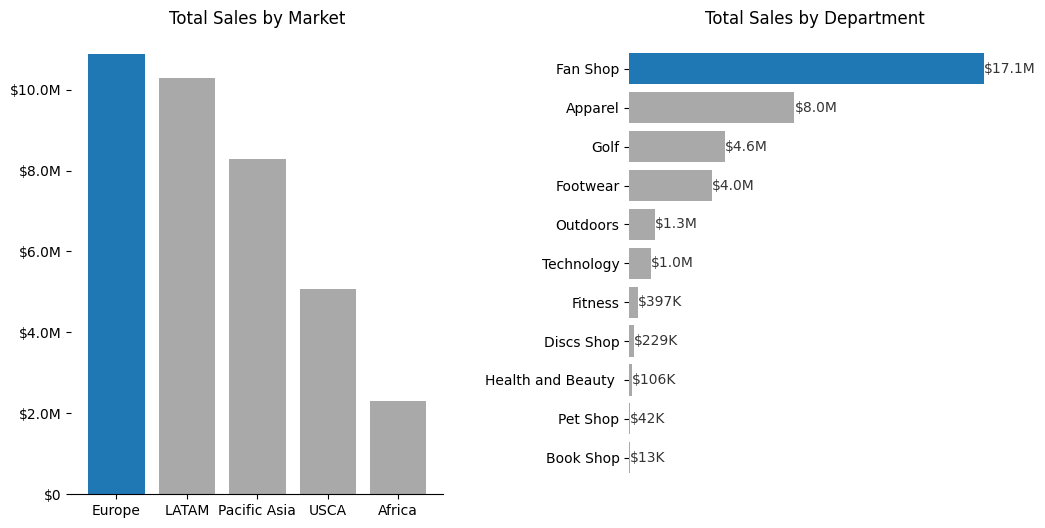

In [11]:
# Get the top markets and departments
top_markets = dict(
    sorted(market_sales.items(), key=lambda item: item[1], reverse=True)[:1]
)
top_department = "Fan Shop"


# Define a currency formatter function
def currency_formatter(x, pos):
    if x >= 1e9:
        return "${:,.1f}B".format(x / 1e9)
    elif x >= 1e6:
        return "${:,.1f}M".format(x / 1e6)
    elif x >= 1e3:
        return "${:,.0f}K".format(x / 1e3)
    else:
        return "${:,.0f}".format(x)


# Create the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sales by market
for market, sales in market_sales.items():
    color = "tab:blue" if market in top_markets else "darkgrey"
    ax[0].bar(market, sales, color=color)

ax[0].set_title("Total Sales by Market")
ax[0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Plot sales by department
for department, sales in department_sales.items():
    color = "tab:blue" if department == top_department else "darkgrey"
    barh = ax[1].barh(department, sales, color=color)
    ax[1].text(
        sales,
        department,
        currency_formatter(sales, None),
        va="center",
        ha="left",
        color="black",
        alpha=0.8,
    )

ax[1].set_title("Total Sales by Department")
ax[1].xaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax[1].spines["bottom"].set_visible(False)
ax[1].xaxis.set_visible(False)

for axes in ax:
    axes.spines[["top", "right", "left"]].set_visible(False)
    axes.set_axisbelow(True)

plt.subplots_adjust(wspace=0.5)
plt.show()

Europe and Latin America (LATAM) seem to be larger markets compared to all other regions combined. Let's look at it on an annual basis.

In [12]:
df.pivot_table(index="Year", columns="Market", values="Sales", aggfunc="sum")

Market,Africa,Europe,LATAM,Pacific Asia,USCA
Year,,,,,
2015,NaN,4.913405e+06,5.072188e+06,2.355238e+06,NaN
2016,2.046623e+06,7.613233e+05,NaN,4.452406e+06,5.043466e+06
2017,2.478302e+05,5.197668e+06,5.205424e+06,1.134450e+06,2.306319e+04
2018,NaN,NaN,NaN,3.316501e+05,NaN


According to the table; 

- The company entered the **African** market in 2016.
- The company stopped its operations in **LATAM** in 2016 and restarted them in 2017.
- The company entered the **USCA** market in 2016.

To maintain consistency, we can only consider **2017** for inventory management processes.


In [13]:
df_ = df.query("Year == 2017")

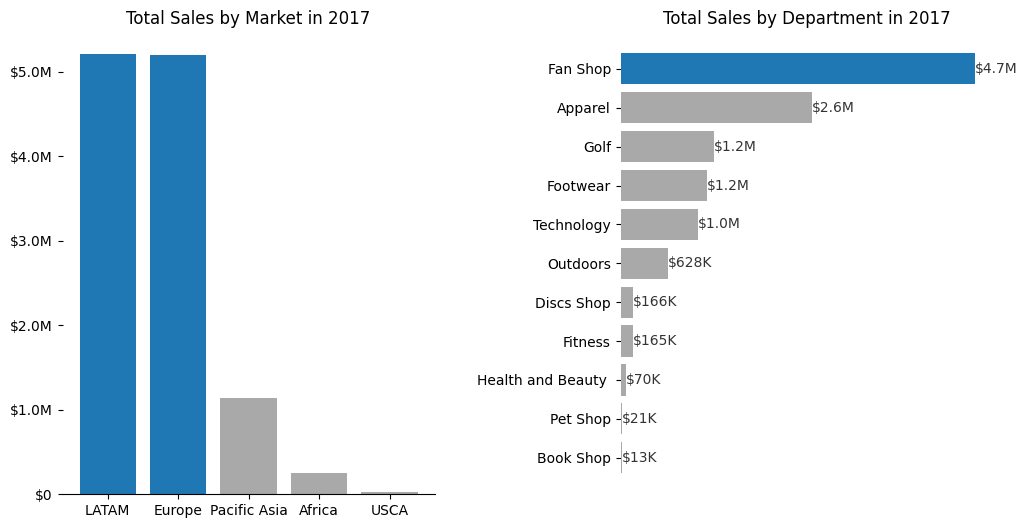

In [14]:
market_sales_2017 = df_.groupby("Market")["Sales"].sum().sort_values(ascending=False)
department_sales_2017 = (
    df_.groupby("Department Name", observed=False)["Sales"]
    .sum()
    .sort_values(ascending=True)
)

top_markets_2017 = dict(
    sorted(market_sales_2017.items(), key=lambda item: item[1], reverse=True)[:2]
)
top_department_2017 = "Fan Shop"

# Create the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sales by market
for market, sales in market_sales_2017.items():
    color = "tab:blue" if market in top_markets_2017 else "darkgrey"
    ax[0].bar(market, sales, color=color)

ax[0].set_title("Total Sales by Market in 2017")
ax[0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Plot sales by department
for department, sales in department_sales_2017.items():
    color = "tab:blue" if department == top_department_2017 else "darkgrey"
    barh = ax[1].barh(department, sales, color=color)
    ax[1].text(
        sales,
        department,
        currency_formatter(sales, None),
        va="center",
        ha="left",
        color="black",
        alpha=0.8,
    )

ax[1].set_title("Total Sales by Department in 2017")
ax[1].xaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax[1].spines["bottom"].set_visible(False)
ax[1].xaxis.set_visible(False)

for axes in ax:
    axes.spines[["top", "right", "left"]].set_visible(False)
    axes.set_axisbelow(True)

plt.subplots_adjust(wspace=0.5)
plt.show()

LATAM and Europe appear to be the largest markets in terms of sales, followed by Pacific Asia, Africa, and USCA.

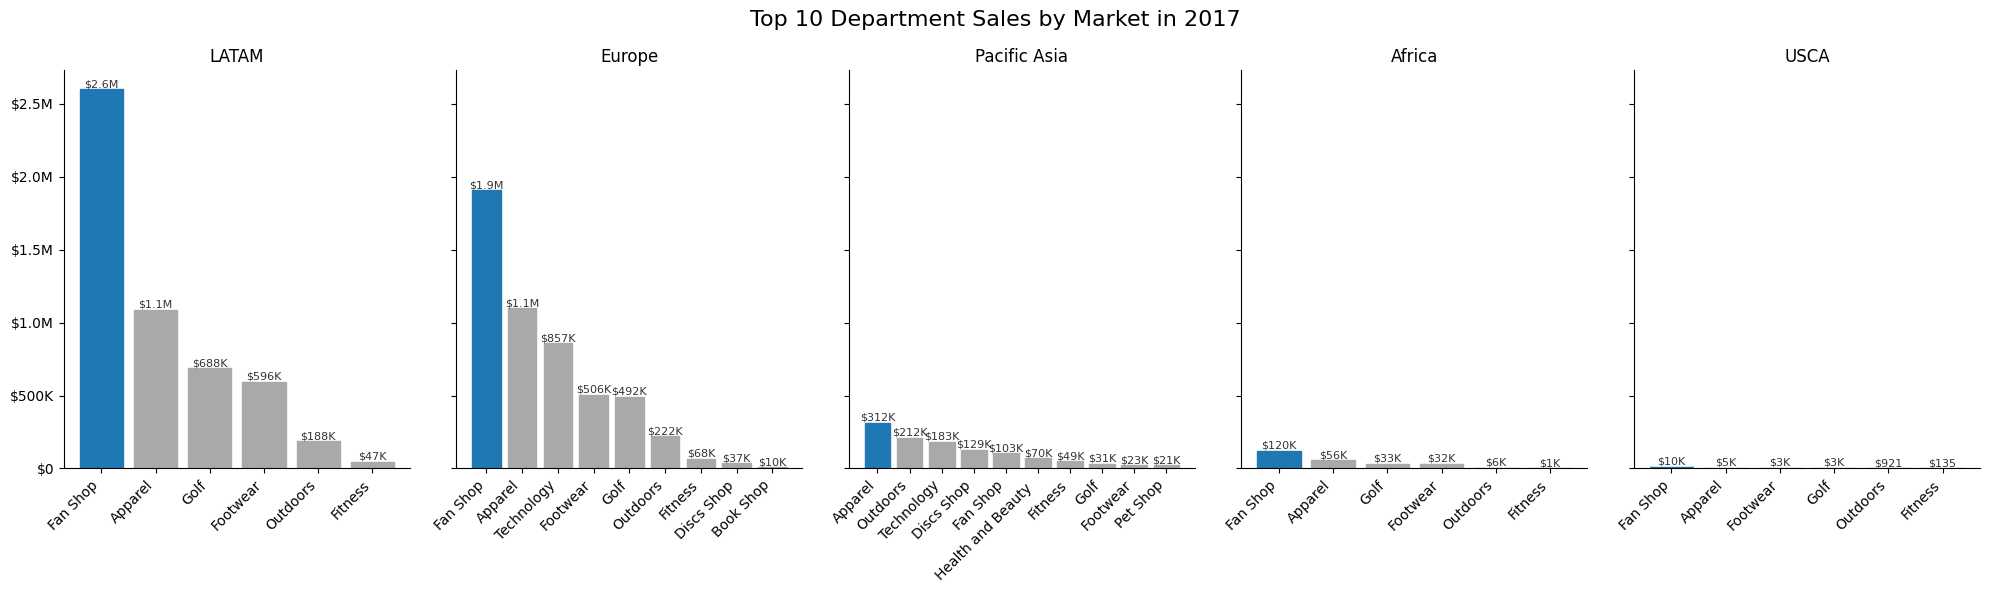

In [15]:
market_sales_idx = (
    df_.groupby("Market")["Sales"].sum().sort_values(ascending=False).index
)
total_sales_by_market_department = (
    df_.groupby(["Market", "Department Name"])["Sales"].sum().reset_index()
)
top5_departments = (
    total_sales_by_market_department.groupby("Market")
    .apply(lambda x: x.nlargest(10, "Sales"))
    .reset_index(drop=True)
)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

for ax, market in zip(axs, market_sales_idx):
    data = top5_departments[top5_departments["Market"] == market]
    max_sales_department = data.loc[data["Sales"].idxmax()]
    bars = ax.bar(data["Department Name"], data["Sales"])
    for bar in bars:
        if bar.get_height() == max_sales_department["Sales"]:
            bar.set_color("tab:blue")
        else:
            bar.set_color("darkgray")

    ax.set_title(market)
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    ax.spines[["top", "right"]].set_visible(False)

    for i, (index, row) in enumerate(data.iterrows()):
        # Use the index of the bar as the x-coordinate
        ax.text(
            i,
            row["Sales"],
            currency_formatter(row["Sales"], None),
            va="bottom",
            ha="center",
            color="black",
            alpha=0.8,
            fontsize=8,
        )
    ax.set_axisbelow(False)
    ax.set_xticklabels(data["Department Name"], rotation=45, ha="right")
fig.suptitle("Top 10 Department Sales by Market in 2017", fontsize=16)
plt.tight_layout()
plt.show()

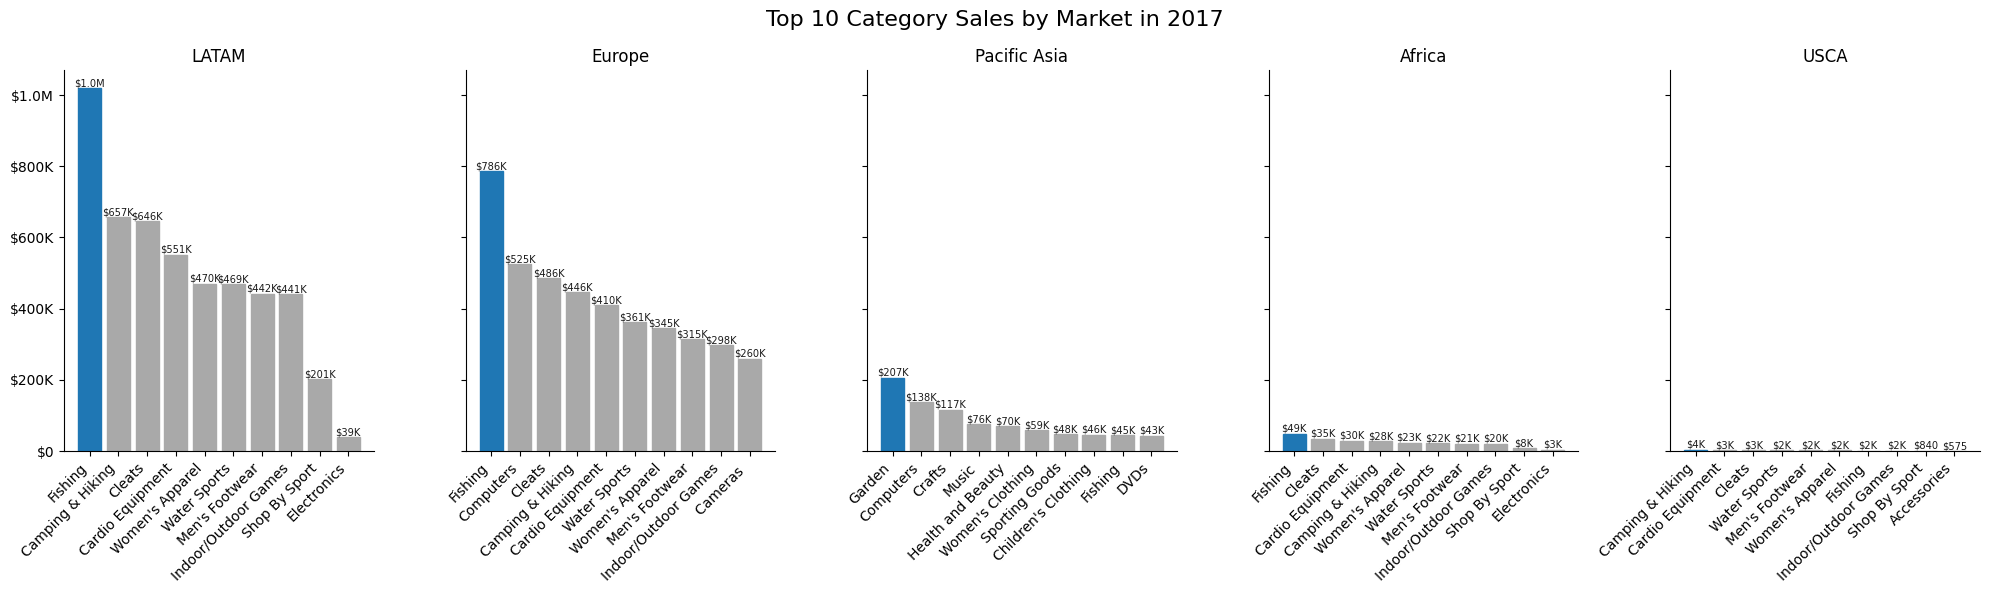

In [16]:
total_sales_by_market_category = (
    df_.groupby(["Market", "Category Name"])["Sales"].sum().reset_index()
)

top5_departments = (
    total_sales_by_market_category.groupby("Market")
    .apply(lambda x: x.nlargest(10, "Sales"))
    .reset_index(drop=True)
)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

for ax, market in zip(axs, market_sales_idx):
    data = top5_departments[top5_departments["Market"] == market]
    max_sales_category = data.loc[data["Sales"].idxmax()]
    bars = ax.bar(data["Category Name"], data["Sales"])
    for bar in bars:
        if bar.get_height() == max_sales_category["Sales"]:
            bar.set_color("tab:blue")
        else:
            bar.set_color("darkgray")

    ax.set_title(market)
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    ax.spines[["top", "right"]].set_visible(False)

    for i, (index, row) in enumerate(data.iterrows()):
        # Use the index of the bar as the x-coordinate
        ax.text(
            i,
            row["Sales"],
            currency_formatter(row["Sales"], None),
            va="bottom",
            ha="center",
            color="black",
            alpha=0.9,
            fontsize=7.1,
        )
    ax.set_axisbelow(False)
    ax.set_xticklabels(data["Category Name"], rotation=45, ha="right")
fig.suptitle("Top 10 Category Sales by Market in 2017", fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
def quantity_formatter(x, pos):
    if x >= 1e9:
        return "{:,.1f}B".format(x / 1e9)
    elif x >= 1e6:
        return "{:,.1f}M".format(x / 1e6)
    elif x >= 1e3:
        return "{:,.0f}K".format(x / 1e3)
    else:
        return "{:,.0f}".format(x)

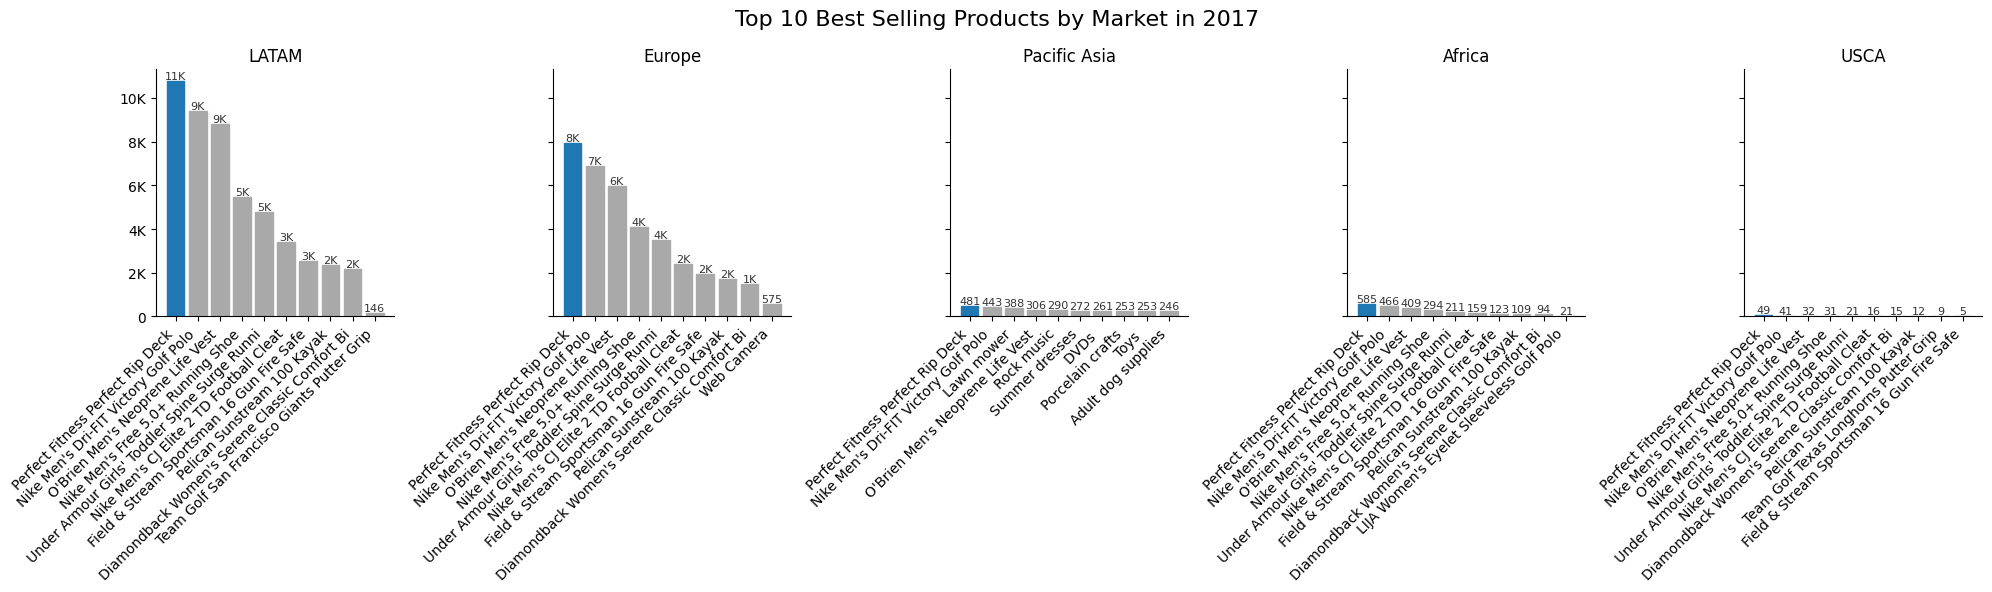

In [18]:
market_order_idx = (
    df_.groupby("Market")["Order Item Quantity"]
    .sum()
    .sort_values(ascending=False)
    .index
)
total_order_by_market_product = (
    df_.groupby(["Market", "Product Name"])["Order Item Quantity"].sum().reset_index()
)

top10_product = (
    total_order_by_market_product.groupby("Market")
    .apply(lambda x: x.nlargest(10, "Order Item Quantity"))
    .reset_index(drop=True)
)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

for ax, market in zip(axs, market_order_idx):
    data = top10_product[top10_product["Market"] == market]
    max_order_product = data.loc[data["Order Item Quantity"].idxmax()]
    bars = ax.bar(data["Product Name"], data["Order Item Quantity"])
    for bar in bars:
        if bar.get_height() == max_order_product["Order Item Quantity"]:
            bar.set_color("tab:blue")
        else:
            bar.set_color("darkgray")

    ax.set_title(market)
    ax.yaxis.set_major_formatter(FuncFormatter(quantity_formatter))
    ax.spines[["top", "right"]].set_visible(False)

    for i, (index, row) in enumerate(data.iterrows()):
        # Use the index of the bar as the x-coordinate
        ax.text(
            i,
            row["Order Item Quantity"],
            quantity_formatter(row["Order Item Quantity"], None),
            va="bottom",
            ha="center",
            color="black",
            alpha=0.8,
            fontsize=8,
        )
    ax.set_axisbelow(False)
    ax.set_xticklabels(data["Product Name"], rotation=45, ha="right")
fig.suptitle("Top 10 Best Selling Products by Market in 2017", fontsize=16)
plt.tight_layout()
plt.show()

The 'Perfect Fitness Perfect Rip Deck' is the top-selling product in all markets. LATAM market shows higher performance in terms of order quantity compared to other markets.

In [19]:
df_.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State',
       'Customer Street', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'order date (DateOrders)',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Name', 'Product Price', 'Product Status',
       'shipping date (DateOrders)', 'Shipping Mode', 'Year'],
      dtype='object')

#### Creating World Map with Geopandas

In [20]:
all_countries_sales = df_.groupby(["Order Country"])["Sales"].sum().reset_index()
all_cities_sales = df_.groupby(["Order City"])["Sales"].sum().reset_index()
all_order_region_sales = df_.groupby(["Order Region"])["Sales"].sum().reset_index()

In [21]:
brasil_sales_query = all_countries_sales.query("`Order Country` == 'Brasil'")

In [22]:
all_countries_sales.shape

(129, 2)

In [23]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [24]:
world.query("name == 'Brazil'")

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
29,211049527.0,South America,Brazil,BRA,1839758,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."


Country names do not match. Let's see which countries don't match.

In [25]:
unmatched_countries = set(all_countries_sales["Order Country"]).difference(
    set(world["name"])
)

In [26]:
unmatched_countries

{'Afganistán',
 'Alemania',
 'Arabia Saudí',
 'Argelia',
 'Azerbaiyán',
 'Bangladés',
 'Barbados',
 'Belice',
 'Benín',
 'Bielorrusia',
 'Bosnia y Herzegovina',
 'Brasil',
 'Bután',
 'Bélgica',
 'Camboya',
 'Camerún',
 'Chipre',
 'Corea del Sur',
 'Costa de Marfil',
 'Croacia',
 'Dinamarca',
 'Egipto',
 'Eslovaquia',
 'España',
 'Filipinas',
 'Finlandia',
 'Francia',
 'Gabón',
 'Grecia',
 'Guadalupe',
 'Guayana Francesa',
 'Haití',
 'Hong Kong',
 'Hungría',
 'Irak',
 'Irlanda',
 'Irán',
 'Italia',
 'Japón',
 'Jordania',
 'Kazajistán',
 'Kenia',
 'Kirguistán',
 'Lituania',
 'Luxemburgo',
 'Líbano',
 'Macedonia',
 'Malasia',
 'Marruecos',
 'Martinica',
 'Moldavia',
 'Myanmar (Birmania)',
 'México',
 'Noruega',
 'Níger',
 'Pakistán',
 'Panamá',
 'Papúa Nueva Guinea',
 'Países Bajos',
 'Perú',
 'Polonia',
 'Reino Unido',
 'República Checa',
 'República Democrática del Congo',
 'República Dominicana',
 'Ruanda',
 'Rumania',
 'Rusia',
 'Singapur',
 'SudAfrica',
 'Suecia',
 'Suiza',
 'Surinam

In [27]:
mapping_dict = {
    "Afganistán": "Afghanistan",
    "Alemania": "Germany",
    "Arabia Saudí": "Saudi Arabia",
    "Argelia": "Algeria",
    "Azerbaiyán": "Azerbaijan",
    "Bangladés": "Bangladesh",
    "Barbados": "Barbados",
    "Baréin": "Bahrain",
    "Belice": "Belize",
    "Benín": "Benin",
    "Bielorrusia": "Belarus",
    "Bosnia y Herzegovina": "Bosnia and Herzegovina",
    "Botsuana": "Botswana",
    "Brasil": "Brazil",
    "Bután": "Bhutan",
    "Bélgica": "Belgium",
    "Camboya": "Cambodia",
    "Camerún": "Cameroon",
    "Chipre": "Cyprus",
    "Corea del Sur": "South Korea",
    "Costa de Marfil": "Ivory Coast",
    "Croacia": "Croatia",
    "Dinamarca": "Denmark",
    "Egipto": "Egypt",
    "Emiratos Árabes Unidos": "United Arab Emirates",
    "Eslovaquia": "Slovakia",
    "Eslovenia": "Slovenia",
    "España": "Spain",
    "Estados Unidos": "United States of America",
    "Etiopía": "Ethiopia",
    "Filipinas": "Philippines",
    "Finlandia": "Finland",
    "Francia": "France",
    "Gabón": "Gabon",
    "Grecia": "Greece",
    "Guadalupe": "Guadeloupe",
    "Guayana Francesa": "French Guiana",
    "Guinea Ecuatorial": "Equatorial Guinea",
    "Haití": "Haiti",
    "Hong Kong": "Hong Kong",
    "Hungría": "Hungary",
    "Irak": "Iraq",
    "Irlanda": "Ireland",
    "Irán": "Iran",
    "Italia": "Italy",
    "Japón": "Japan",
    "Jordania": "Jordan",
    "Kazajistán": "Kazakhstan",
    "Kenia": "Kenya",
    "Kirguistán": "Kyrgyzstan",
    "Lesoto": "Lesotho",
    "Libia": "Libya",
    "Lituania": "Lithuania",
    "Luxemburgo": "Luxembourg",
    "Líbano": "Lebanon",
    "Macedonia": "North Macedonia",
    "Malasia": "Malaysia",
    "Marruecos": "Morocco",
    "Martinica": "Martinique",
    "Moldavia": "Moldova",
    "Myanmar (Birmania)": "Myanmar",
    "México": "Mexico",
    "Noruega": "Norway",
    "Nueva Zelanda": "New Zealand",
    "Níger": "Niger",
    "Omán": "Oman",
    "Pakistán": "Pakistan",
    "Panamá": "Panama",
    "Papúa Nueva Guinea": "Papua New Guinea",
    "Países Bajos": "Netherlands",
    "Perú": "Peru",
    "Polonia": "Poland",
    "Reino Unido": "United Kingdom",
    "República Centroafricana": "Central African Republic",
    "República Checa": "Czech Republic",
    "República Democrática del Congo": "Democratic Republic of the Congo",
    "República Dominicana": "Dominican Republic",
    "República de Gambia": "The Gambia",
    "República del Congo": "Republic of the Congo",
    "Ruanda": "Rwanda",
    "Rumania": "Romania",
    "Rusia": "Russia",
    "Sierra Leona": "Sierra Leone",
    "Singapur": "Singapore",
    "Siria": "Syria",
    "Suazilandia": "Eswatini",
    "SudAfrica": "South Africa",
    "Sudán": "Sudan",
    "Sudán del Sur": "South Sudan",
    "Suecia": "Sweden",
    "Suiza": "Switzerland",
    "Surinam": "Suriname",
    "Sáhara Occidental": "Western Sahara",
    "Tailandia": "Thailand",
    "Taiwán": "Taiwan",
    "Tayikistán": "Tajikistan",
    "Trinidad y Tobago": "Trinidad and Tobago",
    "Turkmenistán": "Turkmenistan",
    "Turquía": "Turkey",
    "Túnez": "Tunisia",
    "Ucrania": "Ukraine",
    "Uzbekistán": "Uzbekistan",
    "Yibuti": "Djibouti",
    "Zimbabue": "Zimbabwe",
}

Let's replace them with their correct names.

In [28]:
all_countries_sales["Order Country"] = all_countries_sales["Order Country"].replace(
    mapping_dict
)

Now we can merge the datasets.

In [29]:
world_sales = world.merge(all_countries_sales, left_on="name", right_on="Order Country")

In [30]:
world_sales.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Order Country,Sales
0,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,12913.420294
1,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,23063.190499
2,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,3589.650062
3,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",Uzbekistan,2642.630039
4,8776109.0,Oceania,Papua New Guinea,PNG,24829,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",Papua New Guinea,425.029999


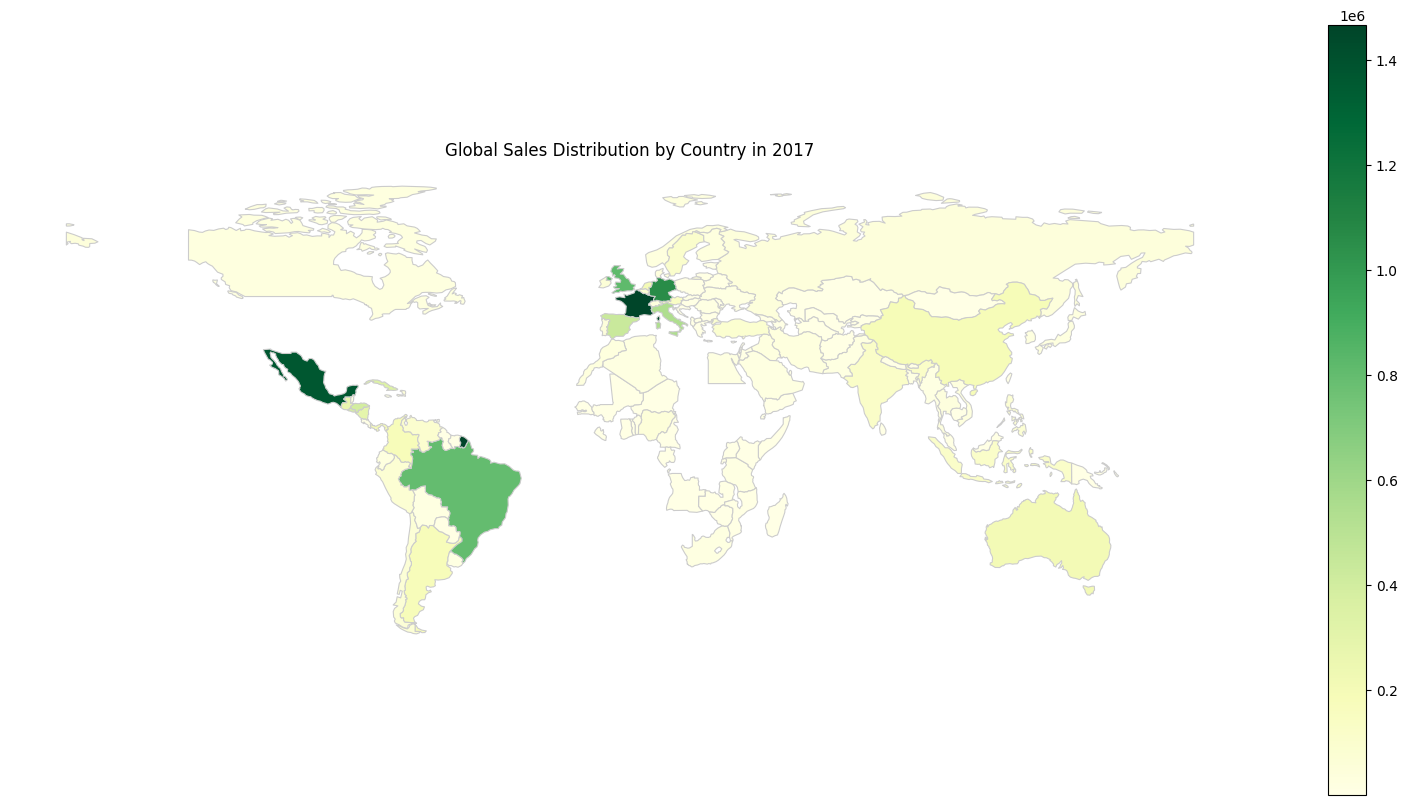

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))
world_sales.plot(
    column="Sales",
    cmap="YlGn",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    ax=plt.gca(),
).set_axis_off()

# Set the title and show the plot
plt.title("Global Sales Distribution by Country in 2017")
plt.show()

In [32]:
# Interactive version of the graph above.
# m = folium.Map(location=[0, 0], zoom_start=3,tiles="cartodb positron")

# folium.Choropleth(
#     geo_data=world_sales,
#     name="choropleth",
#     data=world_sales,
#     columns=["name", "Sales"],
#     key_on="feature.properties.name",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     nan_fill_color="white",

#     legend_name="Sales",
#      highlight=True,

# ).add_to(m)


# folium.GeoJson(
#     data=world_sales,
#     style_function=lambda feature: {
#         "color":"",
#         "weight": 0.2,
#     },
#     tooltip=folium.GeoJsonTooltip(
#         fields=["name", "Sales"],
#         aliases=["Country:", "Sales: "],
#         labels=True,
#         sticky=True,
#         style="background-color: white;"

#         )
#     ).add_to(m)

# m

In [33]:
world_sales.groupby("Order Country")["Sales"].sum().reset_index(
    name="Sales"
).sort_values(by="Sales", ascending=False)[:10]

,Order Country,Sales
34,France,1.466954e+06
65,Mexico,1.371471e+06
37,Germany,1.064684e+06
110,United Kingdom,8.170683e+05
15,Brazil,8.019948e+05
51,Italy,5.422939e+05
96,Spain,4.334722e+05
43,Honduras,3.942301e+05
31,El Salvador,3.758007e+05
25,Cuba,3.386557e+05


Let's check the store's location.

In [34]:
# Load the shapefile containing the boundaries of US states
us_states = gpd.read_file("data\states.shp")

In [35]:
# Group the data by longitude and latitude to count the number of stores at each location
stores_count = (
    df_.groupby(["Longitude", "Latitude"]).size().reset_index(name="Store_Counts")
)

In [36]:
# We need to create Point(longitude,latitude) from Store_count.
# Create a list of Point geometries based on longitude and latitude coordinates
geometry = [
    Point(xy) for xy in zip(stores_count["Longitude"], stores_count["Latitude"])
]

# Add the Point geometries to the stores_count DataFrame as a new column named "point_geometry"
stores_count["point_geometry"] = geometry

In [37]:
# Create a GeoDataFrame from the stores_count DataFrame with Point geometries and EPSG:4326 CRS
stores_gdf = gpd.GeoDataFrame(stores_count, geometry="point_geometry", crs="EPSG:4326")

Stores are mainly in the US, with some outliers.

In [38]:
# Create a GeoDataFrame containing only stores that are within the boundaries of the USA states
stores_gdf_usa = stores_gdf[stores_gdf.within(us_states.unary_union)]

In [39]:
# Perform a spatial join between the GeoDataFrame of stores within the USA and the GeoDataFrame of USA states
gdf_with_states = gpd.sjoin(stores_gdf_usa, us_states, op="within")

In [40]:
# Aggregate store counts by state
state_counts = gdf_with_states.groupby("STATE_NAME")["Store_Counts"].sum().reset_index()

In [41]:
merged_states_counts = pd.merge(us_states, state_counts, on="STATE_NAME")

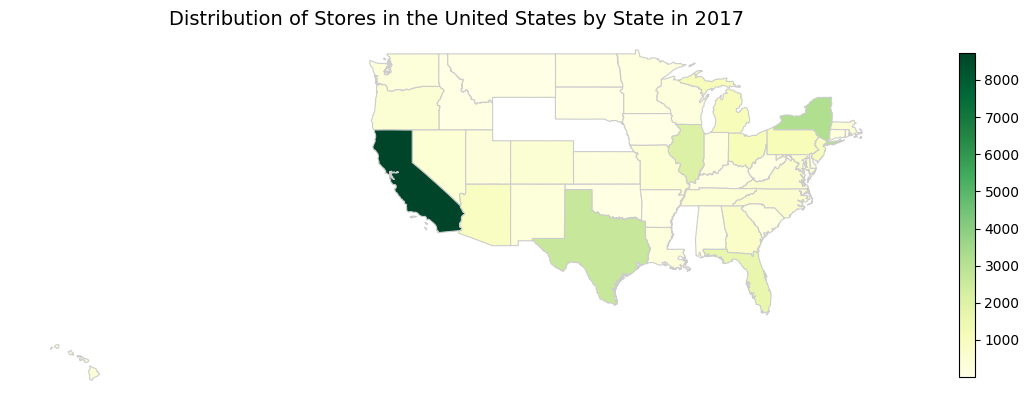

In [42]:
fig, ax = plt.subplots(figsize=(18, 14))

merged_states_counts.plot(
    column="Store_Counts",
    cmap="YlGn",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    ax=ax,
).set_axis_off()
cbar = ax.get_figure().colorbar(ax.collections[0], shrink=0.3)
old_cbar = ax.get_figure().get_axes()[1]
old_cbar.remove()
# Set the title and show the plot
plt.title(
    "Distribution of Stores in the United States by State in 2017",
    fontdict={"fontsize": "14", "fontweight": "1"},
)
plt.show()

It seems that all the customers are located within the US, however, the orders are shipped worldwide. This indicates that the company might be an online shop, where stores across the US are selling their goods online to customers all over the world.

In [43]:
# Interactive version of the graph above
# f = folium.Map(location=[37, -95], zoom_start=5,tiles="cartodb positron")

# folium.Choropleth(
#     geo_data=merged_states_counts,
#     name="choropleth",
#     data=merged_states_counts,
#     columns=["STATE_NAME", "Store_Counts"],
#     key_on="feature.properties.STATE_NAME",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     nan_fill_color="white",

#     legend_name="Store_Counts",
#      highlight=True,

# ).add_to(f)
# f

Let's examine how numerical data is distributed

In [44]:
numerical_df = df_.select_dtypes(include=["int64", "float64"])

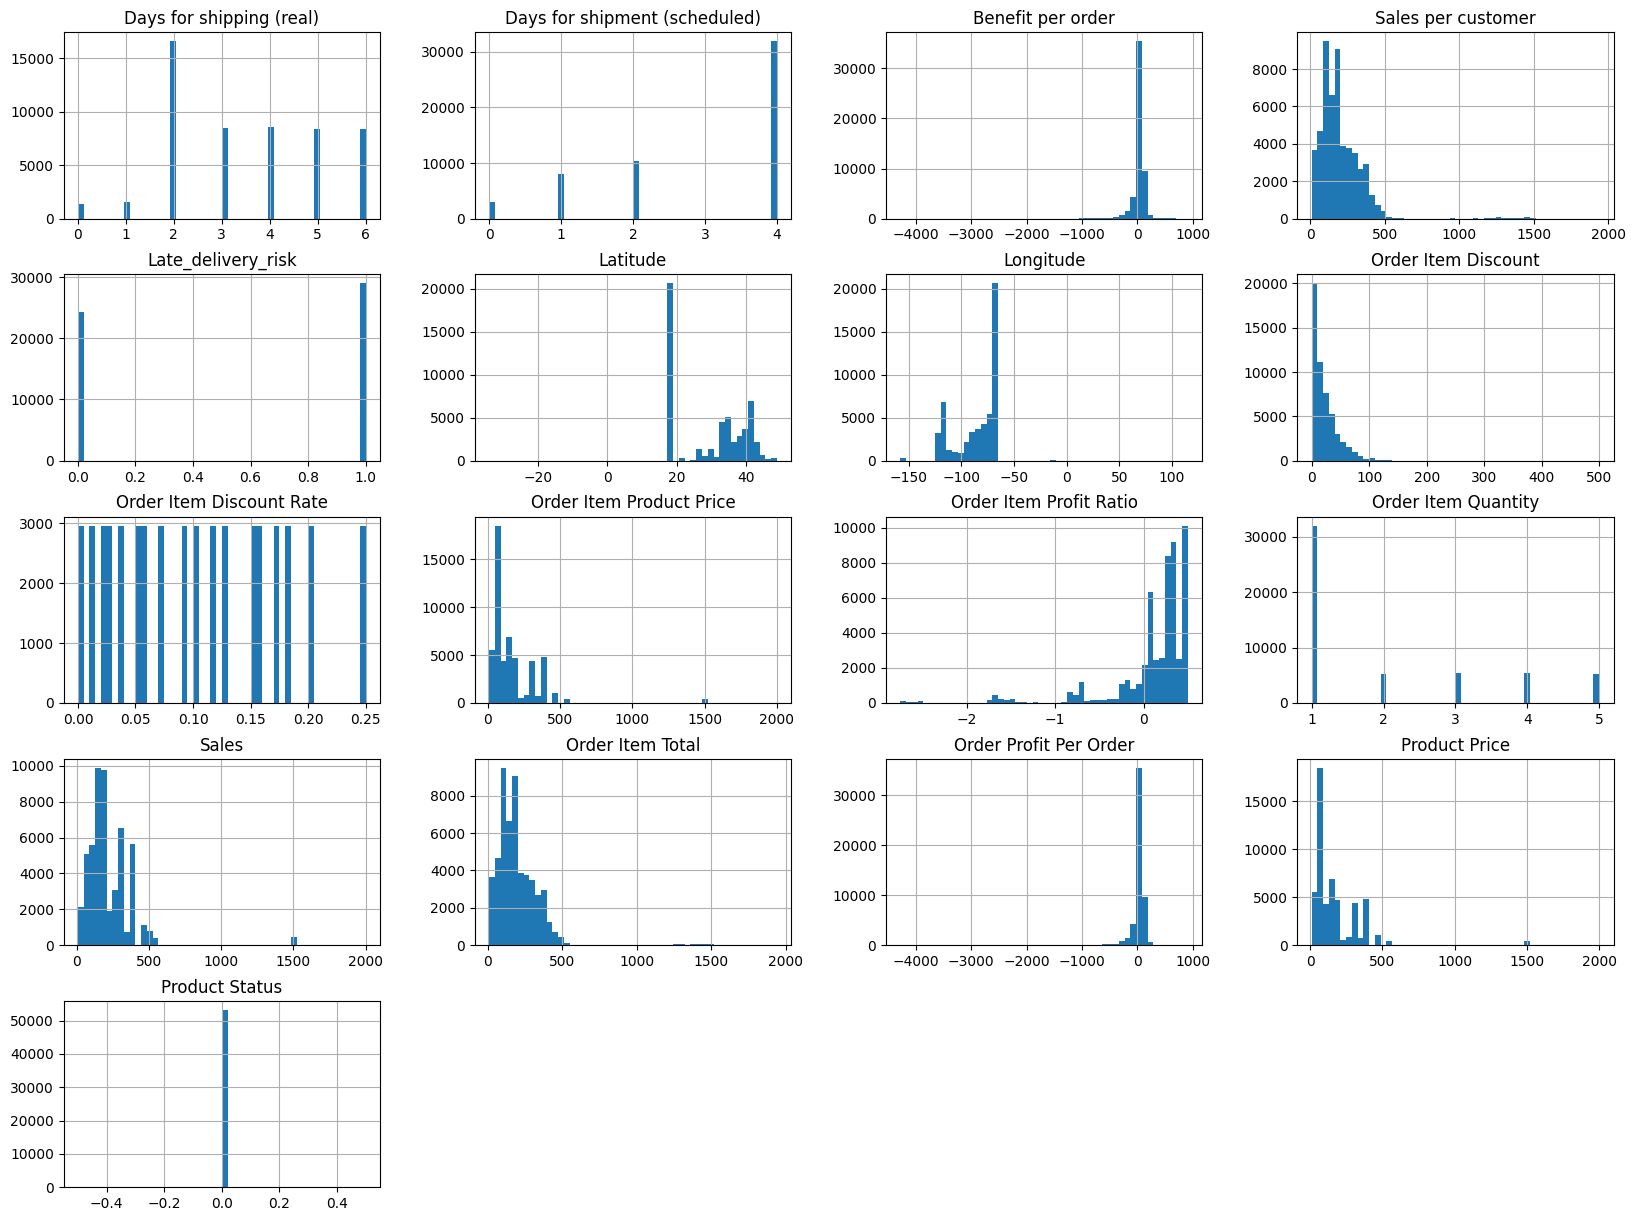

In [45]:
fig, ax = plt.subplots(figsize=(20, 15))
numerical_df.hist(ax=ax, bins=50)
plt.show()

The delivery time for most orders was 4 days, but orders were delivered in 2 days.
Most other distributions are skewed to the right.

In [46]:
df_.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State',
       'Customer Street', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'order date (DateOrders)',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Name', 'Product Price', 'Product Status',
       'shipping date (DateOrders)', 'Shipping Mode', 'Year'],
      dtype='object')

#### Clustering the SKUs

First, to cluster the SKUs, the data needs to be aggregated so that only one row per SKU is obtained.

**What is SKU?**

"SKU" stands for Stock Keeping Unit. It's a term used as a stock tracking unit, commonly in retail sales. It serves as a unique identifier for a product. SKUs can include information about product specifications, supplier details, prices, and they are often readable via barcodes. Businesses such as stores and online sales platforms use SKUs for inventory management and sales tracking purposes.

There are different approaches and methods for segmentation. We will use the inventory management approach. Clustering groups similar SKUs, while ABC Classification emphasizes important SKUs for inventory management strategies.

In [47]:
clustering_features = [
    "Product Name",
    "Order Item Discount",
    "Order Item Discount Rate",
    "Order Item Product Price",
    "Order Item Profit Ratio",
    "Order Item Quantity",
    "Sales",
    "Order Item Total",
    "Order Profit Per Order",
    "Product Price",
    "order date (DateOrders)",
]

df_clustering = df_[clustering_features]

df_clustering_agg = (
    df_clustering.groupby("Product Name")
    .agg(
        {
            "Order Item Quantity": "sum",
            "Order Item Discount Rate": "mean",
            "Sales": "sum",
            "Order Item Profit Ratio": "mean",
        }
    )
    .reset_index()
)

In [48]:
df_clustering_agg.head()

,Product Name,Order Item Quantity,Order Item Discount Rate,Sales,Order Item Profit Ratio
0,Adult dog supplies,246,0.099634,20762.400376,0.094837
1,Baby sweater,207,0.104300,12229.560379,0.139420
2,Bag Boy Beverage Holder,98,0.109143,2449.019973,0.249429
3,Bag Boy M330 Push Cart,208,0.103623,16637.919929,0.184493
4,Bowflex SelectTech 1090 Dumbbells,10,0.138000,5999.899902,0.233000


In [49]:
df_clustering_agg.shape

(118, 5)

The company provides customers with a selection of 118 various products.

array([[<Axes: title={'center': 'Order Item Quantity'}>,
        <Axes: title={'center': 'Order Item Discount Rate'}>],
       [<Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'Order Item Profit Ratio'}>]],
      dtype=object)

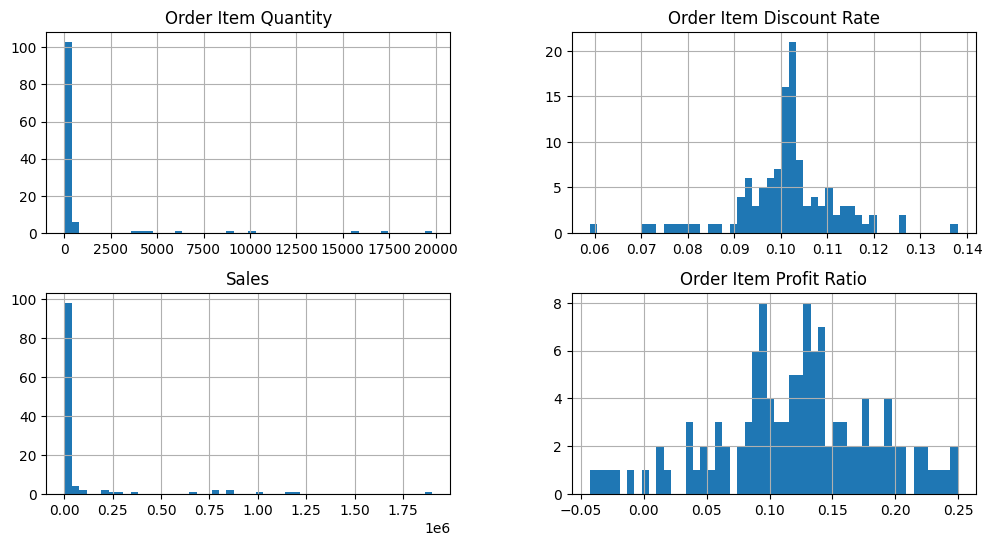

In [50]:
df_clustering_agg.hist(figsize=(12, 6), bins=50)

Most SKUs are rarely sold, but eight SKUs have very high sales volume, indicating that some of the company's products are very popular. To see this more clearly, let's look at it on a pareto chart.

In [51]:
df_cluster_sorted_order = df_clustering_agg.sort_values(
    by="Order Item Quantity", ascending=False
).reset_index(drop=True)

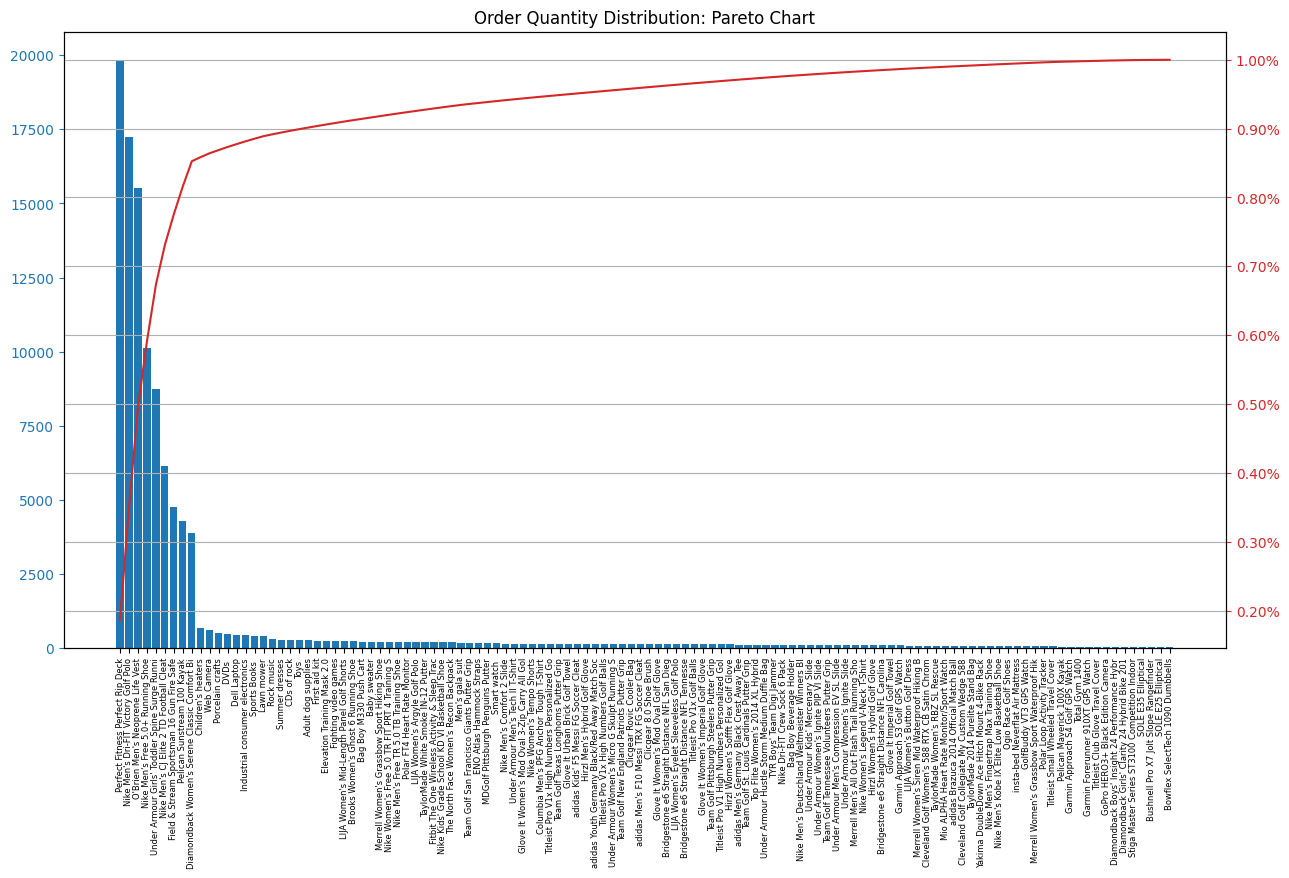

In [52]:
df_cluster_sorted_order["cum_quantity_perc"] = (
    df_cluster_sorted_order["Order Item Quantity"].cumsum()
    / df_cluster_sorted_order["Order Item Quantity"].sum()
)

fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(
    df_cluster_sorted_order["Product Name"],
    df_cluster_sorted_order["Order Item Quantity"],
)
ax.set_xticklabels(
    df_cluster_sorted_order["Product Name"], rotation=90, fontsize=6
)
ax.set_title("Order Quantity Distribution: Pareto Chart")


ax2 = ax.twinx()
ax2.plot(
    df_cluster_sorted_order["Product Name"],
    df_cluster_sorted_order["cum_quantity_perc"],
    color="tab:red",
)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(axis="y")
ax2.set_axisbelow(True)

ax.tick_params(axis="y", colors="tab:blue")
ax2.tick_params(axis="y", colors="tab:red")

plt.show()

As seen in the graph above, only nine out of 118 SKUs accounted for almost 85% of the total order quantity.

In [53]:
# Total order quantity of 9 out of 118 SKUs
df_cluster_sorted_order.head(9)

,Product Name,Order Item Quantity,Order Item Discount Rate,Sales,Order Item Profit Ratio,cum_quantity_perc
0,Perfect Fitness Perfect Rip Deck,19807,0.101641,1.188222e+06,0.135466,0.186640
1,Nike Men's Dri-FIT Victory Golf Polo,17257,0.101407,8.628500e+05,0.128004,0.349252
2,O'Brien Men's Neoprene Life Vest,15530,0.101722,7.761894e+05,0.127727,0.495590
3,Nike Men's Free 5.0+ Running Shoe,10122,0.101597,1.012099e+06,0.126268,0.590969
4,Under Armour Girls' Toddler Spine Surge Runni,8739,0.101426,3.494726e+05,0.105432,0.673316
5,Nike Men's CJ Elite 2 TD Football Cleat,6126,0.101714,7.963188e+05,0.122739,0.731041
6,Field & Stream Sportsman 16 Gun Fire Safe,4751,0.101675,1.900305e+06,0.127076,0.775809
7,Pelican Sunstream 100 Kayak,4281,0.101738,8.561572e+05,0.120500,0.816149
8,Diamondback Women's Serene Classic Comfort Bi,3867,0.101730,1.160023e+06,0.100864,0.852588


Let's look at the pareto chart for “Sales”.

In [54]:
df_cluster_sorted_sales = df_clustering_agg.sort_values(
    by="Sales", ascending=False
).reset_index(drop=True)

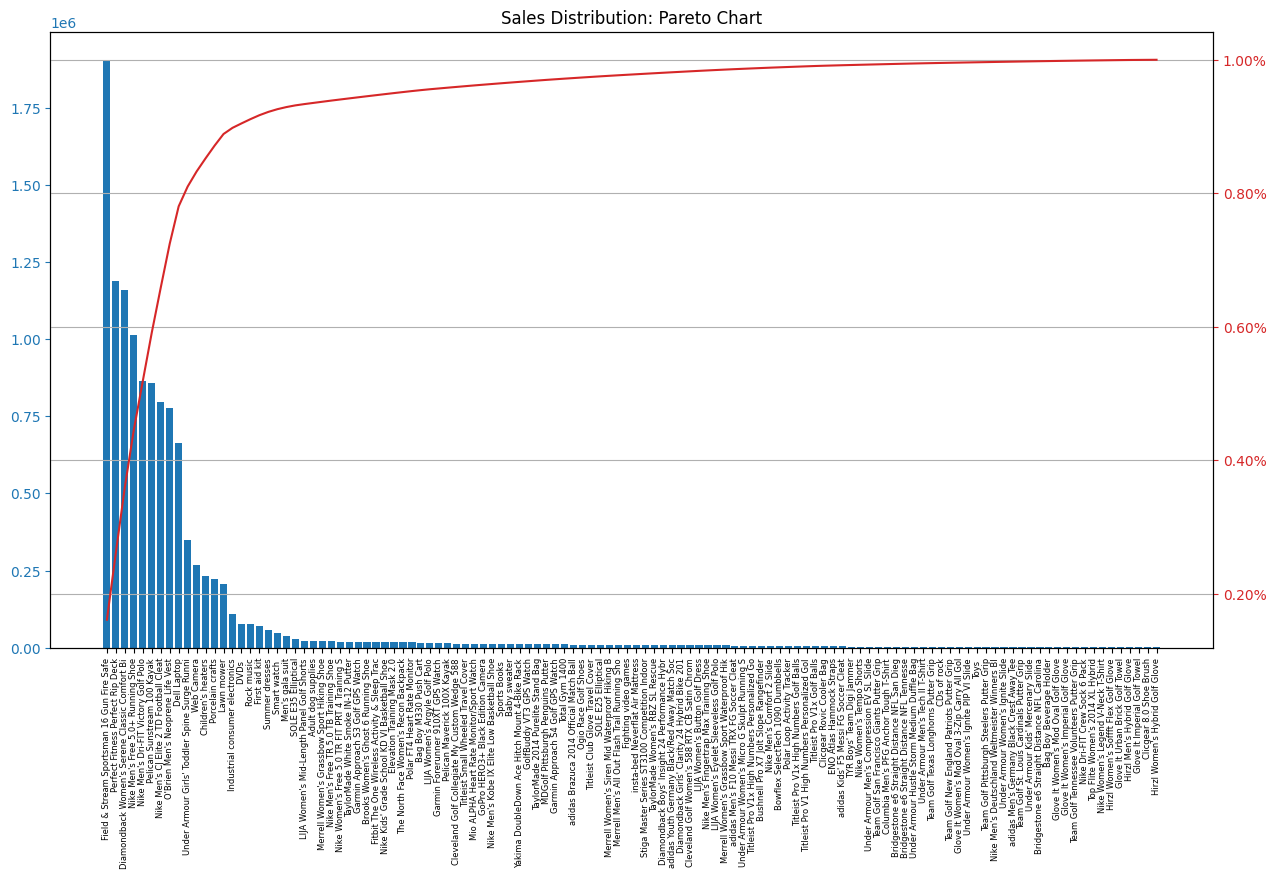

In [55]:
df_cluster_sorted_sales["cum_sales_perc"] = (
    df_cluster_sorted_sales["Sales"].cumsum() / df_cluster_sorted_sales["Sales"].sum()
)

fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(df_cluster_sorted_sales["Product Name"], df_cluster_sorted_sales["Sales"])
ax.set_xticklabels(
    df_cluster_sorted_sales["Product Name"], rotation=90, fontsize=6
)
ax.set_title("Sales Distribution: Pareto Chart")


ax2 = ax.twinx()
ax2.plot(
    df_cluster_sorted_sales["Product Name"],
    df_cluster_sorted_sales["cum_sales_perc"],
    color="tab:red",
)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(axis="y")
ax2.set_axisbelow(True)
ax.tick_params(axis="y", colors="tab:blue")
ax2.tick_params(axis="y", colors="tab:red")

plt.show()

The same interpretation can be made for sales value. Only nine SKUs contribute around 80% of the total sales value over the observed period.

In [56]:
# Total sales of 9 out of 118 SKUs
df_cluster_sorted_sales.head(9)

,Product Name,Order Item Quantity,Order Item Discount Rate,Sales,Order Item Profit Ratio,cum_sales_perc
0,Field & Stream Sportsman 16 Gun Fire Safe,4751,0.101675,1.900305e+06,0.127076,0.160928
1,Perfect Fitness Perfect Rip Deck,19807,0.101641,1.188222e+06,0.135466,0.261553
2,Diamondback Women's Serene Classic Comfort Bi,3867,0.101730,1.160023e+06,0.100864,0.359789
3,Nike Men's Free 5.0+ Running Shoe,10122,0.101597,1.012099e+06,0.126268,0.445499
4,Nike Men's Dri-FIT Victory Golf Polo,17257,0.101407,8.628500e+05,0.128004,0.518570
5,Pelican Sunstream 100 Kayak,4281,0.101738,8.561572e+05,0.120500,0.591074
6,Nike Men's CJ Elite 2 TD Football Cleat,6126,0.101714,7.963188e+05,0.122739,0.658510
7,O'Brien Men's Neoprene Life Vest,15530,0.101722,7.761894e+05,0.127727,0.724242
8,Dell Laptop,442,0.102240,6.630000e+05,0.117059,0.780388


#### Combination of ABCXYZ-Classification

##### ABC Classification:
- ABC classification is a method based on the Pareto Principle. It categorizes items in inventory into three categories: A, B, and C, based on their importance in terms of value or usage.
- Categories:
  - A: High-value or high-usage items requiring close monitoring.
  - B: Moderate-value or moderate-usage items managed with standard control.
  - C: Low-value or low-usage items managed with minimal attention.

##### XYZ Classification:
- Categorizes items based on demand variability or predictability.
- Categories:
  - X: Items with stable and predictable demand.
  - Y: Items with moderate variability in demand.
  - Z: Items with highly unpredictable demand.

##### Combining ABCXYZ-Classification:
- Provides a comprehensive view of inventory.
- Example: AX might be a high-value product with stable demand, needing tight control and accurate forecasting.
- Example: CZ might be a low-value product with highly unpredictable demand, requiring less control but more safety stock.

This approach helps businesses focus their resources on the most valuable items (A) while spending less time on less critical ones (C), saving time and money. It also helps reduce inventory holding costs and prevent stockouts by considering demand variability.

In [57]:
df_abc = df_cluster_sorted_sales[["Product Name", "Sales"]]

# Calculate cumulative sum of Sales and add it as a new column
df_abc["cum_sum"] = df_abc["Sales"].cumsum()

# Calculate cumulative percentage of Sales and add it as a new column
df_abc["cum_per"] = df_abc["cum_sum"] / df_abc["Sales"].sum() * 100

# Add the percentage of each SKU as a new column
df_abc["per"] = df_abc["cum_per"] - df_abc["cum_per"].shift(1)

# Add the first missing value in column "per" to be the first of cumulative percentage
df_abc.loc[0, "per"] = df_abc["cum_per"][0]

In [58]:
# Define function to classify the SKUs based on their cumlated percentage revenue
def abc_classification(data):
    if data["cum_per"] <= 70:
        return "A"
    elif data["cum_per"] > 70 and data["cum_per"] <= 95:
        return "B"
    elif data["cum_per"] > 95:
        return "C"

In [59]:
df_abc["abc"] = df_abc.apply(abc_classification, axis=1)

abc_summary = (
    df_abc[["abc", "Product Name", "Sales"]]
    .groupby("abc")
    .agg(Revenue=("Sales", "sum"), count=("Product Name", "count"))
)

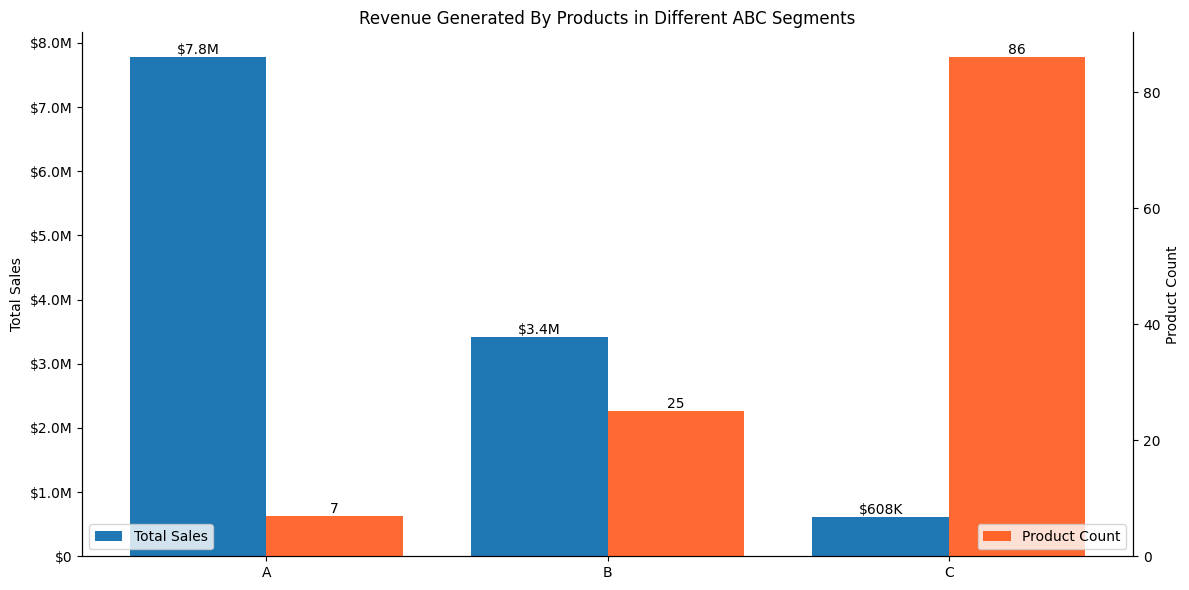

In [60]:
# Function to display bar values
def display_bar_values(bars, ax, formatter=None):
    for bar in bars:
        height = bar.get_height()
        # Apply the formatter if provided
        if formatter:
            formatted_height = formatter(height)
        else:
            formatted_height = str(height)
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            formatted_height,
            ha="center",
            va="bottom",
        )


# Wrap currency_formatter to accept a single argument
def currency_formatter_wrapper(x):
    return currency_formatter(x, 0)


fig, ax = plt.subplots(figsize=(12, 6))

cat_index = list(range(len(abc_summary.index)))
offset = 0.2
bar_width = 0.4

# Plot "Revenue" on the first y-axis
x_revenue = [i - offset for i in cat_index]
bars1 = ax.bar(
    x_revenue,
    abc_summary["Revenue"],
    0.4,
    label="Total Sales",
    alpha=1,
    color="tab:blue",
)
ax.set_ylabel("Total Sales")
ax.set_xticks(range(len(abc_summary.index)))
ax.set_xticklabels(abc_summary.index)
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Create a secondary y-axis for the "Product Count"
ax2 = ax.twinx()

# Plot "Product Count" on the secondary y-axis
x_product_count = [i + offset for i in cat_index]
bars2 = ax2.bar(
    x_product_count,
    abc_summary["count"],
    0.4,
    label="Product Count",
    alpha=0.8,
    color="orangered",
)
ax2.set_ylabel("Product Count")

# Set the title and legend
plt.title("Revenue Generated By Products in Different ABC Segments")
ax.legend(loc="lower left")
ax2.legend(loc="lower right")

# Hide the top and right spines
ax.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)


# Display values for "Revenue" bars
display_bar_values(bars1, ax, formatter=currency_formatter_wrapper)

# Display values for "Product Count" bars
display_bar_values(bars2, ax2)


# Adjust layout
plt.tight_layout()
plt.show()

- Only 7 products contribute around 67% of our total sales, while 86 contribute only 5%. These products are vital to our store, demanding a high level of service. Maintaining safety stock is imperative to ensure we never run out of them. It is important to have various suppliers for A-class products to prevent revenue loss and customer migration to competitors due to product shortages.
- The 25 products in category B contribute 28% of total sales. This category may represent products of medium importance. Procurement processes and inventory management may need to be planned more carefully.
- The 86 products in category C contribute around 5% of total sales. This category may represent lower value and more common products. Supply chain managers must continuously make improvements to optimize stock levels of these products and increase efficiency.
- Priority should be given to class A products when allocating capital and stocking space, followed by class B products. Class C products, which generate the least revenue, should have minimal inventory. With 86 products in Class C, excess inventory not only takes up significant stocking space but also ties up capital unnecessarily.


Let's analyze segment A products by country to prioritize inventory based on regional customer preferences

In [61]:
# Selecting the top 5 country based on total order item revenue
top5_countries = df_.groupby("Order Country")["Sales"].sum().nlargest(5).index.tolist()

In [62]:
# Filtering the data for the top 6 cities and grouping by city and product name to calculate total revenue
country_sales = (
    df_[df_["Order Country"].isin(top5_countries)]
    .groupby(["Order Country", "Product Name"], as_index=False)
    .agg(Revenue=("Sales", "sum"))
)

In [63]:
# Replace country names with formal names
country_sales["Order Country"].replace(
    {
        "Reino Unido": "United Kingdom",
        "México": "Mexico",
        "Francia": "France",
        "Brasil": "Brazil",
        "Alemania": "Germany",
    },
    inplace=True,
)

In [64]:
city_product_revenue_sorted = country_sales.sort_values(
    by=["Order Country", "Revenue"], ascending=False
)

In [65]:
# Calculating the total revenue for each order country again for later use
city_product_revenue_sorted["Total_Country_Revenue"] = (
    city_product_revenue_sorted.groupby("Order Country")["Revenue"].transform("sum")
)

In [66]:
# Calculating the cumulative percentage of total revenue per country per product
city_product_revenue_sorted["cum_per"] = (
    city_product_revenue_sorted.groupby("Order Country")["Revenue"].cumsum()
    / city_product_revenue_sorted["Total_Country_Revenue"]
    * 100
)

In [67]:
# Applying the ABC segmentation function to determine the segment for each product in each country
city_product_revenue_sorted["Segment"] = city_product_revenue_sorted.apply(
    abc_classification, axis=1
)

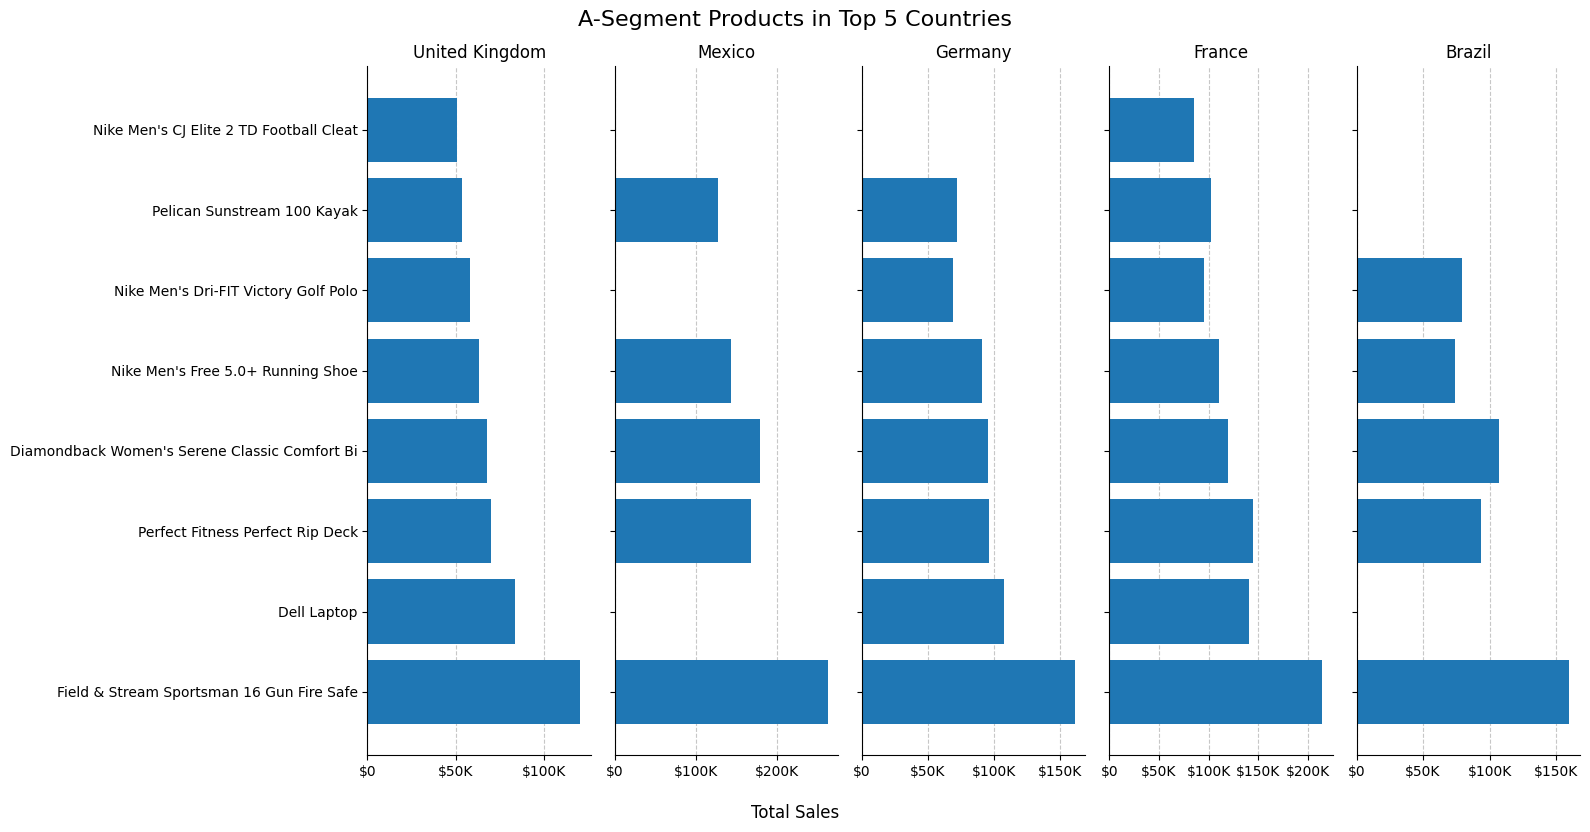

In [68]:
segment_A_data = city_product_revenue_sorted[
    city_product_revenue_sorted["Segment"] == "A"
]

fig, axs = plt.subplots(
    1, len(segment_A_data["Order Country"].unique()), figsize=(16, 8), sharey=True
)

for i, country in enumerate(segment_A_data["Order Country"].unique()):
    country_data = segment_A_data[segment_A_data["Order Country"] == country]
    country_data_sorted = country_data.sort_values(by="Revenue", ascending=True)
    ax = axs[i]
    bars = ax.barh(country_data["Product Name"], country_data["Revenue"])
    ax.set_title(country)
    ax.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
    ax.spines[["top", "right"]].set_visible(False)

    # Set the zorder of the bars to a higher value than the grid lines
    for bar in bars:
        bar.set_zorder(2)

    # Add grid and set the zorder of the grid lines to a lower value than the bars
    ax.grid(axis="x", linestyle="--", alpha=0.7, fillstyle="left")
    for line in ax.get_xgridlines():
        line.set_zorder(1)

plt.suptitle("A-Segment Products in Top 5 Countries", fontsize=16)
fig.text(0.5, -0.03, "Total Sales", ha="center", fontsize=12)
plt.tight_layout()
plt.show()

- Overall, the "Field & Stream Sportsman 16 Gun Fire Safe" consistently shows the highest sales across all five countries, indicating it is a top-performing product in the A-segment. Other products show variability in sales performance depending on the country, highlighting regional preferences and market dynamics.

#### XYZ Classification

In [69]:
df_clustering_cp = df_clustering.copy()

In [70]:
df_clustering_cp["Year"] = df_clustering_cp["order date (DateOrders)"].dt.year
df_clustering_cp["Month"] = df_clustering_cp["order date (DateOrders)"].dt.month

In [71]:
df_cp_agg = (
    df_clustering_cp.groupby(["Product Name", "Year", "Month"])["Order Item Quantity"]
    .sum()
    .reset_index()
)

In [72]:
df_cp_agg["Month"] = df_cp_agg["Month"].map("{:02}".format)
df_cp_agg["Year_Month"] = (
    df_cp_agg["Year"].astype(str) + "-" + df_cp_agg["Month"].astype(str)
)

In [73]:
df_cp_agg.head()

,Product Name,Year,Month,Order Item Quantity,Year_Month
0,Adult dog supplies,2017,11,127,2017-11
1,Adult dog supplies,2017,12,119,2017-12
2,Baby sweater,2017,10,82,2017-10
3,Baby sweater,2017,12,125,2017-12
4,Bag Boy Beverage Holder,2017,01,11,2017-01


In [74]:
df_cp_wide = (
    df_cp_agg.pivot(
        index="Product Name", columns="Year_Month", values="Order Item Quantity"
    )
    .reset_index()
    .fillna(0)
)

In [75]:
df_cp_wide.head()

Year_Month,Product Name,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,Adult dog supplies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,119.0
1,Baby sweater,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,0.0,125.0
2,Bag Boy Beverage Holder,11.0,30.0,33.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bag Boy M330 Push Cart,0.0,0.0,0.0,4.0,70.0,33.0,25.0,52.0,24.0,0.0,0.0,0.0
4,Bowflex SelectTech 1090 Dumbbells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,0.0,0.0


In [76]:
df_cp_wide["total_demand"] = df_cp_wide.iloc[:, 1:13].sum(axis=1)

In [77]:
# calculating average monthly demand by Product Name
df_cp_wide["avg_demand"] = df_cp_wide.iloc[:, 1:13].mean(axis=1)

In [78]:
df_cp_wide["std_dev"] = df_cp_wide.iloc[:, 1:13].std(axis=1)

In [79]:
df_cp_wide["cov"] = df_cp_wide["std_dev"] / df_cp_wide["avg_demand"]

In [80]:
print("Minimum Covariance:", df_cp_wide["cov"].min())
print("Mean Covariance:", df_cp_wide["cov"].mean())
print("Maximum Covariance:", df_cp_wide["cov"].max())

Minimum Covariance: 0.5920622207504581
Mean Covariance: 1.8221988285468964
Maximum Covariance: 3.4641016151377553


- The minimum Covariance of 0.59 suggests that some products have relatively stable demand patterns.
- The overall mean Covariance of 1.82 implies a moderate level of demand variability across the dataset.
- The maximum Covariance of 3.46 indicates significant variability in demand for certain products, potentially due to factors like seasonality or fluctuations in customer preferences.

That means this dataset includes lots of products with fluctuating or seasonal demand, which is going to make things much harder for procurement staff to keep in check.

In [81]:
def xyz_classification(cov):

    if cov <= 0.6:
        return "X"
    elif cov >= 0.6 and cov <= 1.0:
        return "Y"
    else:
        return "Z"

In [82]:
df_cp_wide["xyz"] = df_cp_wide["cov"].apply(xyz_classification)

In [83]:
df_cp_wide[["xyz", "Product Name", "total_demand"]].groupby("xyz").agg(
    total_demand=("total_demand", "sum"), count=("Product Name", "count")
)

,total_demand,count
xyz,,
X,81741.0,8
Y,8739.0,1
Z,15644.0,109


In [84]:
df_cp_wide.head()

Year_Month,Product Name,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,total_demand,avg_demand,std_dev,cov,xyz
0,Adult dog supplies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,119.0,246.0,20.500000,47.908056,2.336978,Z
1,Baby sweater,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,0.0,125.0,207.0,17.250000,41.317232,2.395202,Z
2,Bag Boy Beverage Holder,11.0,30.0,33.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0,8.166667,13.092908,1.603213,Z
3,Bag Boy M330 Push Cart,0.0,0.0,0.0,4.0,70.0,33.0,25.0,52.0,24.0,0.0,0.0,0.0,208.0,17.333333,23.940583,1.381187,Z
4,Bowflex SelectTech 1090 Dumbbells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,0.0,0.0,10.0,0.833333,2.124889,2.549866,Z


In [85]:
total_demand_by_month_xyz = df_cp_wide.groupby("xyz").agg(
    Jan=("2017-01", "sum"),
    Feb=("2017-02", "sum"),
    Mar=("2017-03", "sum"),
    Apr=("2017-04", "sum"),
    May=("2017-05", "sum"),
    Jun=("2017-06", "sum"),
    Jul=("2017-07", "sum"),
    Aug=("2017-08", "sum"),
    Sep=("2017-09", "sum"),
    Oct=("2017-10", "sum"),
    Nov=("2017-11", "sum"),
    Dec=("2017-12", "sum"),
)

In [86]:
total_demand_by_month_xyz

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
xyz,,,,,,,,,,,,
X,9247.0,9013.0,9208.0,8946.0,9146.0,8444.0,9210.0,9225.0,8883.0,419.0,0.0,0.0
Y,1053.0,771.0,992.0,1014.0,1015.0,906.0,1054.0,917.0,992.0,25.0,0.0,0.0
Z,1305.0,1286.0,1476.0,1229.0,872.0,844.0,827.0,953.0,627.0,2046.0,2055.0,2124.0


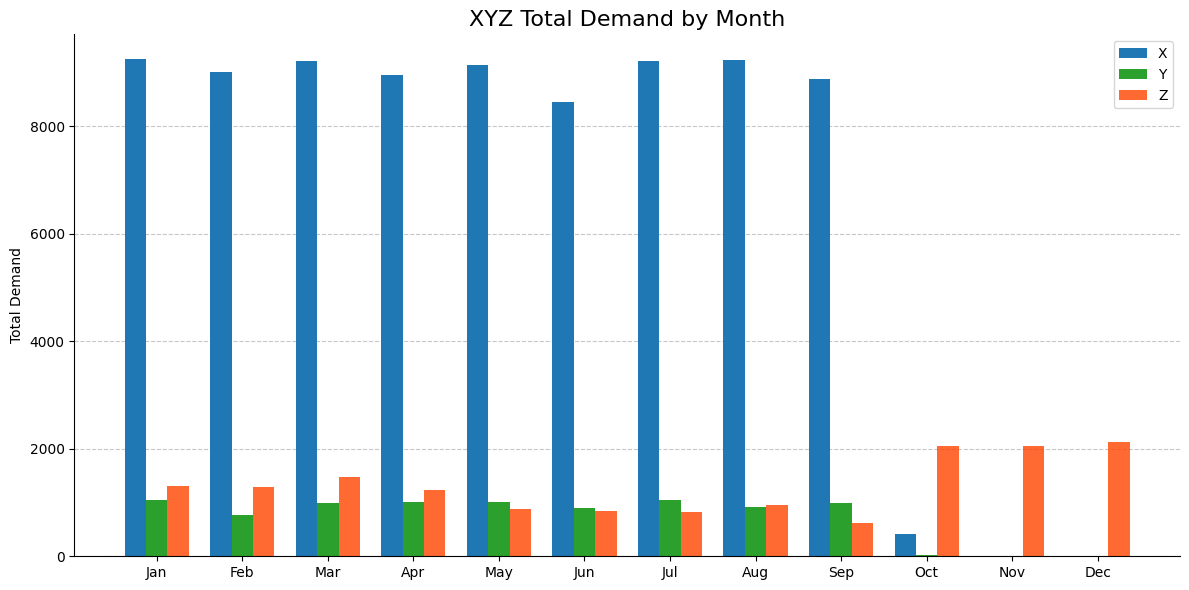

In [87]:
plt.figure(figsize=(12, 6))

bar_width = 0.25
index = total_demand_by_month_xyz.columns
x = range(len(index))

# Plot the bars
plt.bar(
    x, total_demand_by_month_xyz.loc["X"], width=bar_width, label="X", color="tab:blue"
)
plt.bar(
    [i + bar_width for i in x],
    total_demand_by_month_xyz.loc["Y"],
    width=bar_width,
    label="Y",
    color="tab:green",
)
plt.bar(
    [i + 2 * bar_width for i in x],
    total_demand_by_month_xyz.loc["Z"],
    width=bar_width,
    label="Z",
    alpha=0.8,
    color="orangered",
)

# Adjust the spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Set labels and title
plt.ylabel("Total Demand")
plt.title("XYZ Total Demand by Month", fontsize=16)

# Set x-ticks
plt.xticks([i + bar_width for i in x], index)

# Add grid
plt.grid(axis="y", linestyle="--", alpha=0.7, fillstyle="left")

# Set the zorder of the bars to a higher value than the grid lines
for container in plt.gca().containers:
    for bar in container:
        bar.set_zorder(2)

# Access the grid lines through the current axes and set their zorder
for line in plt.gca().get_ygridlines():
    line.set_zorder(1)

# Add legend
plt.legend()
# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

Based on the data in the table:

- There is a noticeable seasonal variation among the XYZ categories. Particularly, category Z's sales show a significant increase in October, November, and December compared to other months. This indicates that category Z is more seasonal and experiences higher demand during these months.
- Category X's sales have a more balanced distribution, but there is a noticeable decrease in October compared to other months. This suggests that the category receives lower demand in October compared to other months.
- Similarly, category Y's sales are generally evenly distributed, but there is a significant decrease in October compared to other months. This indicates that the category experiences lower demand in October.

In conclusion, based on the data in the table, there is seasonal variability among the XYZ categories, with category Z showing higher demand in October, November, and December.

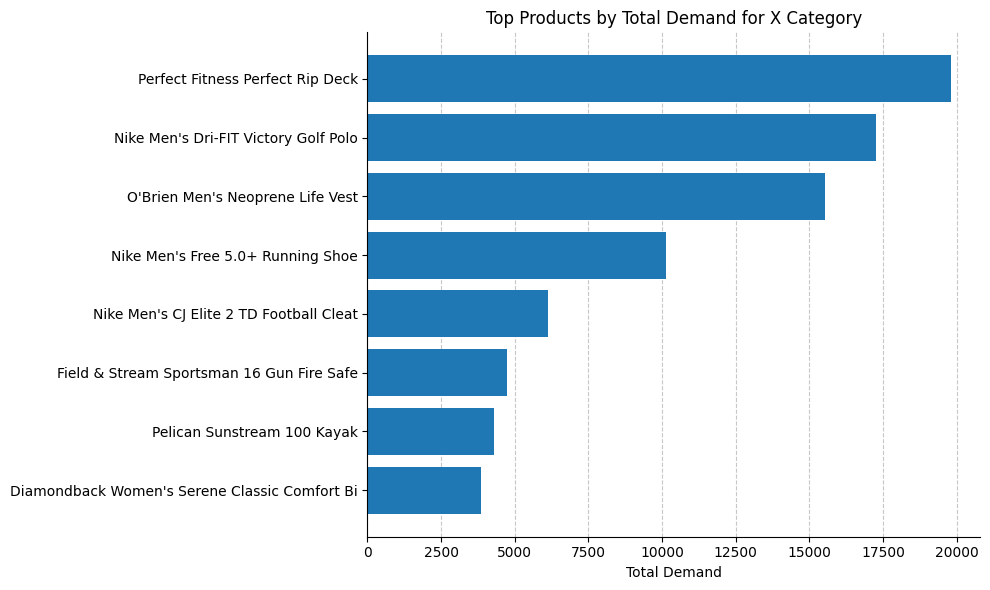

In [88]:
df_x = df_cp_wide[df_cp_wide["xyz"] == "X"].sort_values(
    by="total_demand", ascending=False
)

plt.figure(figsize=(10, 6))
bars = plt.barh(df_x["Product Name"], df_x["total_demand"], color="tab:blue")

# Set the zorder of the bars to a higher value than the grid lines
for bar in bars:
    bar.set_zorder(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Total Demand")
plt.title("Top Products by Total Demand for X Category")
plt.gca().invert_yaxis()

# Add the grid and set the zorder of the grid lines to a lower value than the bars
plt.grid(axis="x", linestyle="--", alpha=0.7, fillstyle="left")

# Access the grid lines through the current axes and set their zorder
for line in plt.gca().get_xgridlines():
    line.set_zorder(1)

plt.tight_layout()
plt.show()

- **High-Demand SKUs**: The "Perfect Fitness Perfect Rip Deck" and "Nike Men's Dri-FIT Victory Golf Polo" show significantly higher total demands. These products are key drivers of revenue and require robust inventory management to ensure consistent availability.
- **Moderate-Demand SKUs**: Products like the "O'Brien Men's Neoprene Life Vest" and "Nike Men's Free 5.0+ Running Shoe" have moderate demand. They benefit from automatic replenishment but may not need as high a buffer as high-demand items.
- **Lower-Demand SKUs**: Items such as the "Diamondback Women's Serene Classic Comfort Bike" have lower demand, suggesting a need for careful management to avoid overstocking while ensuring availability when needed.

In [89]:
df_abc_xyz = df_abc.merge(df_cp_wide, on="Product Name", how="left")

In [90]:
df_abc_xyz["abc_xyz"] = df_abc_xyz["abc"].astype(str) + df_abc_xyz["xyz"].astype(str)

In [91]:
df_abc_xyz_summary = (
    df_abc_xyz.groupby("abc_xyz")
    .agg(
        total_skus=("Product Name", "nunique"),
        total_demand=("total_demand", sum),
        avg_demand=("avg_demand", "mean"),
        total_revenue=("Sales", sum),
    )
    .reset_index()
)

df_abc_xyz_summary.sort_values(by="total_revenue", ascending=False)

,abc_xyz,total_skus,total_demand,avg_demand,total_revenue
0,AX,7,66211.0,788.226190,7.775974e+06
3,BZ,23,6550.0,23.731884,2.299083e+06
1,BX,1,15530.0,1294.166667,7.761894e+05
4,CZ,86,9094.0,8.812016,6.077169e+05
2,BY,1,8739.0,728.250000,3.494726e+05


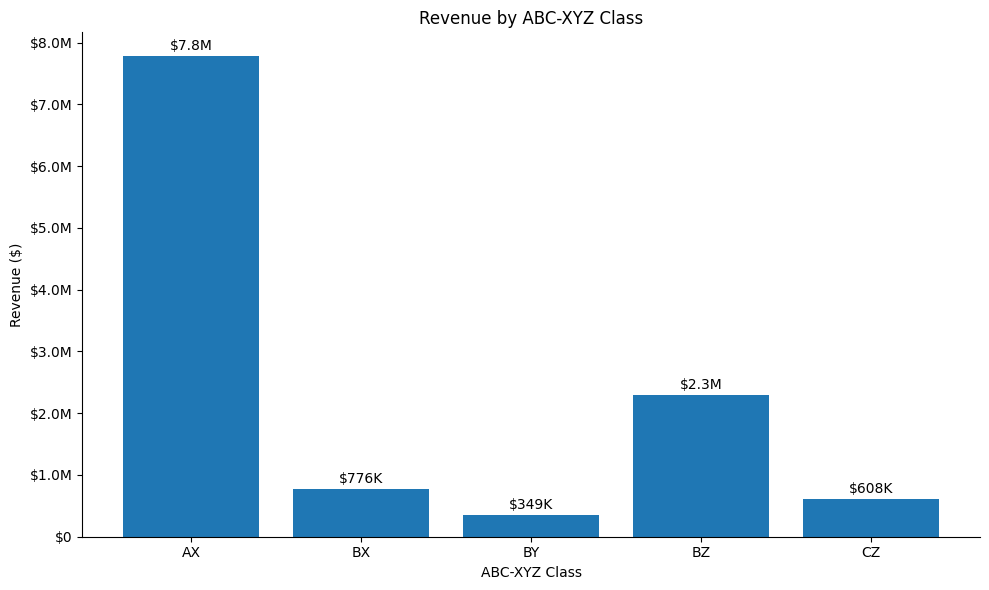

In [92]:
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(
    df_abc_xyz_summary["abc_xyz"], df_abc_xyz_summary["total_revenue"], color="tab:blue"
)

# Add labels and title
plt.xlabel("ABC-XYZ Class")
plt.ylabel("Revenue ($)")
plt.title("Revenue by ABC-XYZ Class")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Add value labels on top of each bar
for i in range(len(df_abc_xyz_summary["abc_xyz"])):
    plt.text(
        i,
        df_abc_xyz_summary["total_revenue"][i] + 100000,
        currency_formatter_wrapper(df_abc_xyz_summary["total_revenue"][i]),
        ha="center",
    )

# Format y-axis ticks using the currency_formatter function
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))

# Display the plot
plt.tight_layout()
plt.show()

- Combining ABC and XYZ data yields nine distinct classes that offer key insights for supply chain management. Classes with an A prefix significantly contribute to high revenue, making them crucial for resource allocation. B Classes generate medium revenue, requiring efficient planning, while C Classes contribute low revenue but still need attention for overall balance.

- X suffixed Classes have stable, predictable demand, making them easier to forecast and manage. Y Classes have variable but manageable demand, necessitating a flexible approach. Z Classes are the most challenging, with sporadic and varying demand, requiring robust forecasting and agile strategies.

- Understanding these classes' revenue contributions and demand patterns allows supply chain analysts to optimize resources, improve forecasting accuracy, and enhance overall supply chain performance.

The [Association of International Certified Professional Accountants](https://www.aicpa-cima.com/resources/article/abc-xyz-inventory-management) provides practical guidance on applying ABC XYZ classifications for procurement managers to maximize revenue and profit without excessive capital investment in stock. They recommend the following approaches:

### Management Approaches for XYZ Inventory Analysis

| Class | Value    | Demand       | Forecastability | Management  |
|---------|----------|--------------|-----------------|-------------|
| AX      | High     | Steady       | Easy            | Easy        |
| BX      | Medium   | Steady       | Easy            | Easy        |
| BY      | Medium   | Variable     | Hard            | Hard        |
| BZ      | Medium   | Sporadic     | Difficult       | Difficult   |
| CZ      | Low      | Sporadic     | Difficult       | Difficult   |




1. **AX Class (High Revenue, Stable Demand)**:
   - Implement automatic replenishment systems to ensure stock levels are maintained.
   - Use a low buffer inventory strategy, JIT (Just-In-Time) approach, or consignment transfers to minimize excess stock.
   - Utilize perpetual inventory tracking for real-time visibility into stock levels.

2. **BX Class (Moderate Revenue, Stable Demand)**:
   - Adopt automatic replenishment systems to streamline stock management.
   - Conduct periodic counting to verify inventory accuracy and adjust stock levels as needed.
   - Maintain a low buffer inventory to balance stock availability and capital tied up.

3. **CX Class (Low Revenue, Stable Demand)**:
   - Employ automatic replenishment systems for efficient stock replenishment.
   - Use periodic estimation methods to forecast demand and adjust stock levels accordingly.
   - Maintain a low buffer inventory to optimize capital utilization.

4. **AY Class (High Revenue, Variable Demand)**:
   - Opt for semi-automatic replenishment methods to manage fluctuating demand effectively.
   - Maintain a low buffer inventory to avoid overstocking while meeting demand variations.

5. **BY Class (Moderate Revenue, Variable Demand)**:
   - Implement semi-automatic replenishment processes with manual adjustments for seasonal demand changes.
   - Manage stock with a carefully adjusted seasonal buffer to optimize stock levels.

6. **CY Class (Low Revenue, Variable Demand)**:
   - Use semi-automatic replenishment approaches to handle demand fluctuations efficiently.
   - Maintain a higher buffer inventory to ensure stock availability during demand peaks.

7. **AZ Class (Buy to Order, No Buffer)**:
   - Source products on-demand to minimize inventory holding costs.
   - Avoid stocking these items and display lead times to customers to manage expectations.

8. **BZ Class (Buy to Order, No Buffer with Lead Time Shown)**:
   - Procure items based on customer orders to reduce inventory costs.
   - Clearly communicate lead times to customers to manage delivery expectations.

9. **CZ Class (Automatic Replenishment, High Buffer)**:
   - Use automatic replenishment systems with a higher buffer inventory to meet variable demand.
   - Conduct periodic inspections to ensure stock levels align with demand patterns.

Implementing these management approaches based on ABC XYZ classifications can help optimize inventory management, reduce stockouts, and improve overall supply chain efficiency.



## Demand Forecasting
In this section, we explore time series demand forecasting, a critical part of supply chain and inventory management.

#### Objectives
- Forecasting demand for the upcoming month (4 weeks ahead)

#### Evaluation Metrics
-  Symmetric Mean Absolute Percentage Error
-  Mean Absolute Error

#### Methods
- We will focus on using [Nixtla](https://nixtlaverse.nixtla.io/) open-source libraries

  - Statistical model
    - MSTL model (Multiple Seasonal-Trend decomposition using LOESS)
  
  - Generative pre-trained transformer model 
    - TimeGPT

In [93]:
# Import libraries
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasetsforecast.losses import mae, smape
from dotenv import load_dotenv
from nixtla import NixtlaClient
from statsforecast import StatsForecast as sf
from statsforecast.models import MSTL, AutoARIMA
from statsmodels.tsa.stattools import adfuller
from utilsforecast.evaluation import evaluate

In [94]:
demand_df = pd.read_csv("data/ts_demand_forecasting_train.csv")

In [95]:
demand_df.shape

(8589, 13)

In [96]:
demand_df.head()

,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY
0,store_130_SKU_120931082,2019-05-06,388.0,44.0,69.0,55.428571,8.182443,243.0,1.0,44.8,store_130,SKU_120931082,cat_1160
1,store_130_SKU_120931082,2019-05-13,318.0,37.0,62.0,45.428571,8.079958,210.0,1.0,44.8,store_130,SKU_120931082,cat_1160
2,store_130_SKU_120931082,2019-05-20,126.0,13.0,23.0,18.000000,3.915780,118.0,0.0,44.8,store_130,SKU_120931082,cat_1160
3,store_130_SKU_120931082,2019-05-27,285.0,23.0,65.0,40.714286,14.067863,197.0,1.0,44.8,store_130,SKU_120931082,cat_1160
4,store_130_SKU_120931082,2019-06-03,93.0,10.0,20.0,13.285714,3.352327,87.0,0.0,44.8,store_130,SKU_120931082,cat_1160


In [97]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STORE_SKU         8589 non-null   object 
 1   DATE              8589 non-null   object 
 2   UNITS             8589 non-null   float64
 3   UNITS_MIN         8589 non-null   float64
 4   UNITS_MAX         8589 non-null   float64
 5   UNITS_MEAN        8589 non-null   float64
 6   UNITS_STD         8589 non-null   float64
 7   TRANSACTIONS_SUM  8589 non-null   float64
 8   PROMO_MAX         8589 non-null   float64
 9   PRICE_MEAN        8589 non-null   float64
 10  STORE             8589 non-null   object 
 11  SKU               8589 non-null   object 
 12  SKU_CATEGORY      8589 non-null   object 
dtypes: float64(8), object(5)
memory usage: 872.4+ KB


In [98]:
date_col = "DATE"
series_id = "STORE_SKU"
target = "UNITS"

In [99]:
# Convert the date column to datetime format
demand_df[date_col] = pd.to_datetime(demand_df[date_col])

print(f"Min date: {demand_df[date_col].min()}")
print(f"Max date: {demand_df[date_col].max()}")

Min date: 2019-05-06 00:00:00
Max date: 2022-10-24 00:00:00


In [100]:
series_dupl_dates = demand_df.groupby([series_id, date_col]).size()
series_dupl_dates = series_dupl_dates[series_dupl_dates > 1]
print("# of series with duplicate dates:", len(series_dupl_dates))

# of series with duplicate dates: 0


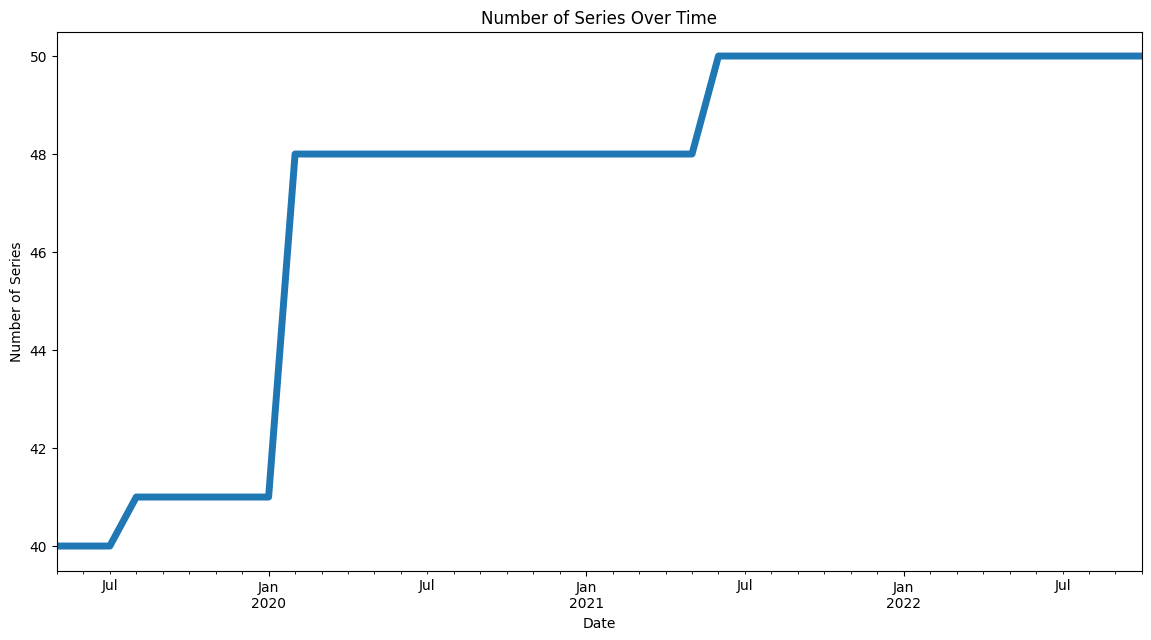

In [101]:
# Check the number of series over time
series_over_time = demand_df.groupby(demand_df[date_col].dt.to_period("M"))[
    series_id
].nunique()
series_over_time.plot(
    kind="line", figsize=(14, 7), title="Number of Series Over Time", linewidth=5
)
plt.xlabel("Date")
plt.ylabel("Number of Series")
plt.show()

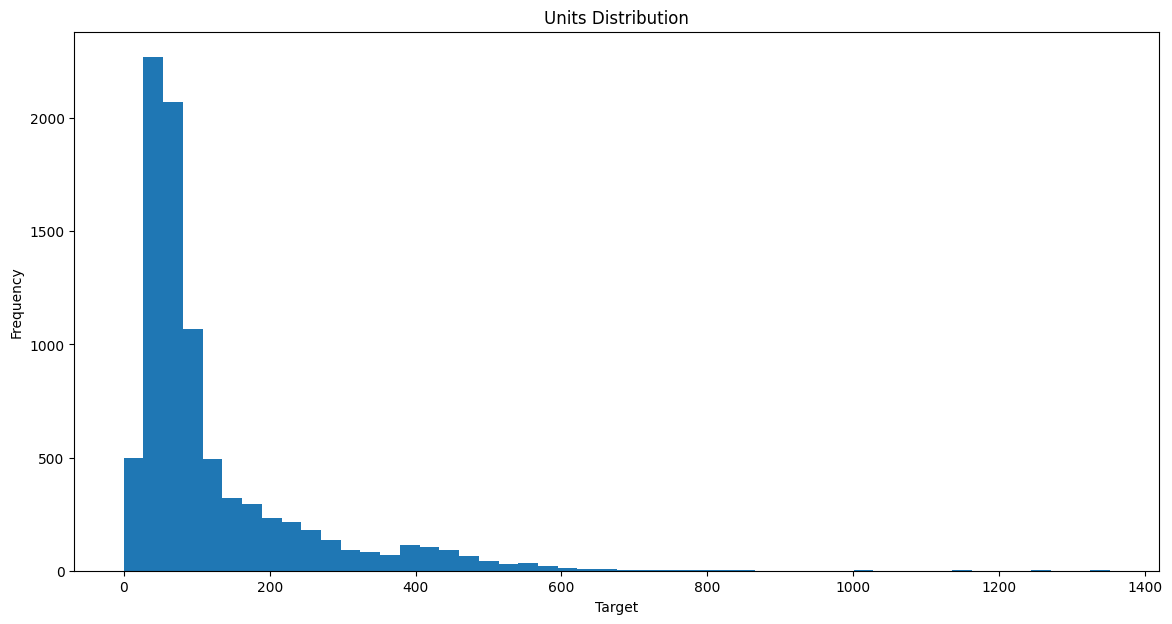

In [102]:
# Plot the target distribution
demand_df[target].plot(
    kind="hist", bins=50, figsize=(14, 7), title="Units Distribution"
)
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()

- The target variable shows a right-skewed distribution. Most of the data points are clustered between 0 and 200 units.
- We might consider transforming the target variable (using a logarithmic transformation) to normalize the distribution.

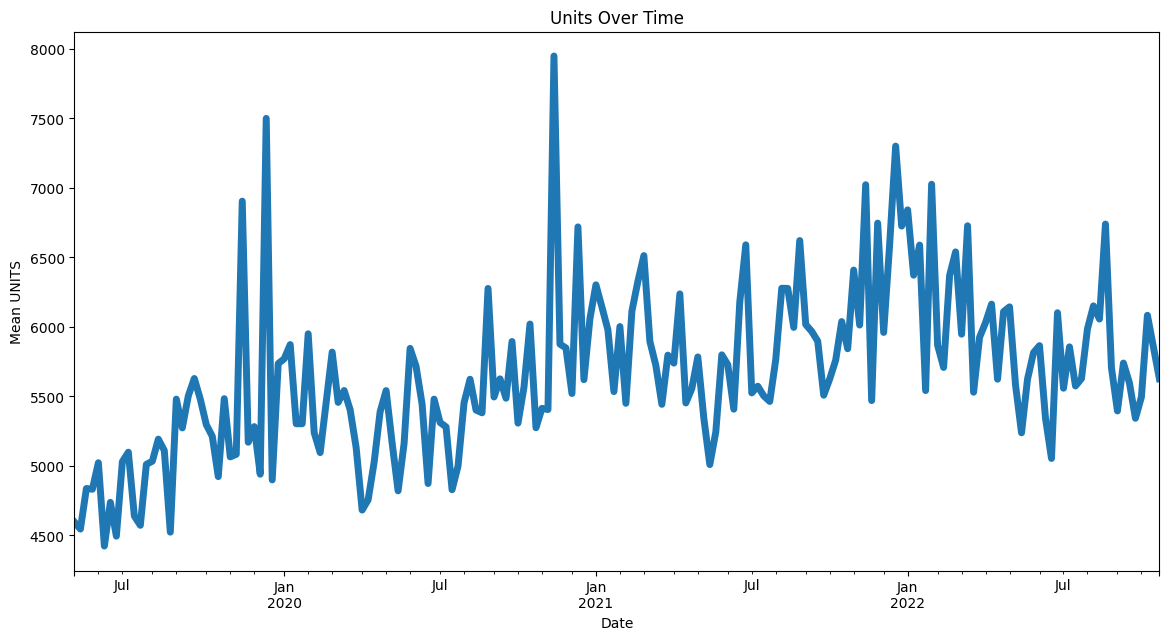

In [103]:
# Plot the target over time
target_over_time = demand_df.groupby(demand_df[date_col].dt.to_period("W-MON"))[
    target
].sum()
target_over_time.plot(
    kind="line", figsize=(14, 7), title="Units Over Time", linewidth=5
)
plt.xlabel("Date")
plt.ylabel("Mean UNITS")
plt.show()

In [104]:
# Compute and print missing data
total_entries = demand_df.shape[0]
non_missing_entries = demand_df[target].notnull().sum()
sparsity = (total_entries - non_missing_entries) / total_entries
print(f"Data sparsity: {sparsity:.2%}")

Data sparsity: 0.00%


In [105]:
# Compute per series statistics
per_series_stats = demand_df.groupby(series_id)[target].agg(
    ["count", "mean", "std", "min", "max"]
)
print("Per series statistics:")
pd.DataFrame(per_series_stats)

Per series statistics:


,count,mean,std,min,max
STORE_SKU,,,,,
store_130_SKU_120931082,182,127.401099,75.008129,32.00,415.00
store_130_SKU_120969795,182,46.098901,20.505789,9.00,111.00
store_133_SKU_9888998,182,46.986264,16.841909,13.57,95.72
store_136_SKU_120973845,182,88.274725,19.139249,48.00,141.00
store_137_SKU_120949681,182,232.565934,63.624534,122.00,715.00
store_137_SKU_909891669,182,55.846154,30.827778,17.00,155.00
store_139_SKU_120939045,141,50.503546,18.971642,0.00,84.00
store_140_SKU_120931082,182,83.461538,51.095363,27.00,278.00
store_141_SKU_120930437,182,396.197802,56.082855,243.00,547.00


- The mean values represent the average sales volume for each SKU-store combination, which is essential for establishing baseline demand levels.
- High standard deviations indicate fluctuating demand, which suggests the need for advanced forecasting techniques to account for variability.
- Low standard deviations indicate more consistent demand, suitable for simpler forecasting models.
- Minimum values of zero are present in several series, indicating periods with no sales, which could be due to stockouts, low demand, or product lifecycle events.
- Maximum values vary widely, reflecting peak sales periods likely influenced by promotions, seasonality, or other factors.

#### Identify Series with High Variability

First, let's identify the series with the highest standard deviations, which indicate high variability in units.

In [106]:
# Identify series with the highest standard deviations
top_var_series = per_series_stats.sort_values(by="std", ascending=False).head().index

#### Plot Sales Over Time for High Variability Series
We will plot the sales data for these high variability series to visually inspect the spikes and dips.

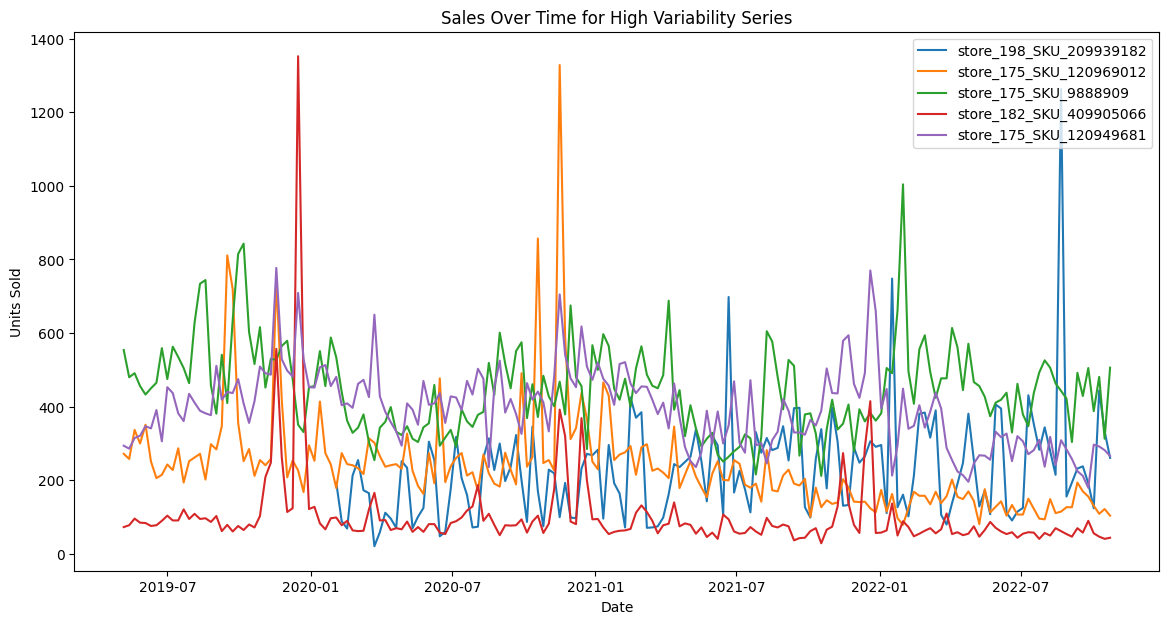

In [107]:
# Identify series with the highest standard deviations
top_var_series = per_series_stats.sort_values(by="std", ascending=False).head().index

# Plot sales over time for high variability series
plt.figure(figsize=(14, 7))
for series in top_var_series:
    series_data = demand_df[demand_df[series_id] == series].set_index(date_col)["UNITS"]
    plt.plot(series_data, label=series)
plt.title("Sales Over Time for High Variability Series")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

The plot illustrates the sales over time for the series with the highest standard deviations.
#### Spikes:
- Several series, such as **store_198_SKU_209939182**, **store_175_SKU_120969012**, and **store_175_SKU_9888909**, show notable spikes in sales. These spikes may correspond to specific events like promotions, seasonal demand, or market interventions.
- The spikes are particularly noticeable around early 2020 and late 2021, suggesting potential external influences or business activities that led to increased sales during these periods.
  
#### Dips:
- Dips in sales are also evident in the series, notably around mid-2020 and early 2021. These dips might indicate periods of low demand, stockouts, or changes in market conditions.

#### Calculate and Plot Rolling Statistics

To further analyze the variability, we will calculate and plot the rolling mean and standard deviation.

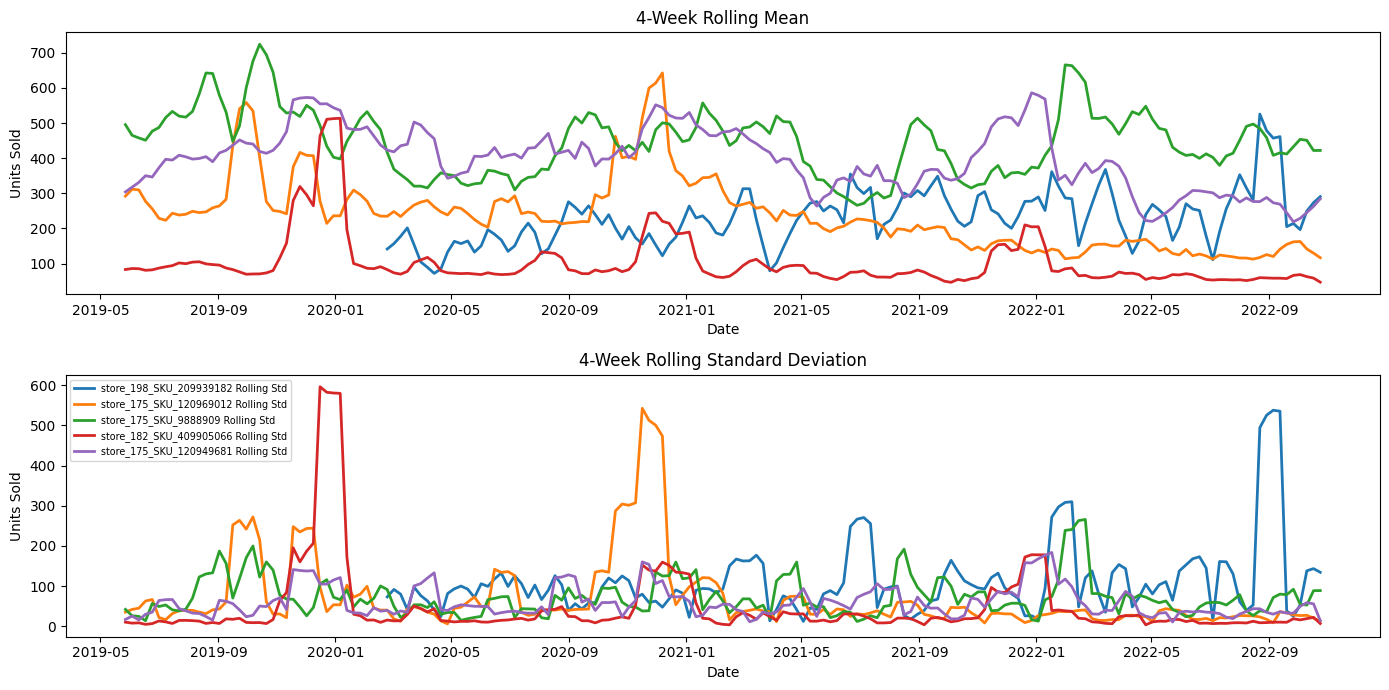

In [108]:
# Plot rolling mean and standard deviation for high variability series
window = 4
plt.figure(figsize=(14, 7))
for series in top_var_series:
    series_data = demand_df[demand_df[series_id] == series].set_index(date_col)["UNITS"]
    rolling_mean = series_data.rolling(window=window).mean()
    rolling_std = series_data.rolling(window=window).std()

    plt.subplot(2, 1, 1)
    plt.plot(rolling_mean, label=f"{series} Rolling Mean", linewidth=2)
    plt.title(f"{window}-Week Rolling Mean")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")

    plt.subplot(2, 1, 2)
    plt.plot(rolling_std, label=f"{series} Rolling Std", linewidth=2)
    plt.title(f"{window}-Week Rolling Standard Deviation")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")

plt.legend(fontsize="x-small")
plt.tight_layout()
plt.show()

#### Rolling Mean
The plot (top) shows the rolling mean of the sales data for the top variability series, providing insight into the overall trends over time.

- Series like **store_175_SKU_120969012** show a generally decreasing trend over time, suggesting a decline in sales.
- Conversely, some series like **store_198_SKU_209939182** exhibit an increasing trend towards the end of the period, indicating growing sales.

#### Rolling Standard Deviation
The plot (bottom) illustrates the rolling standard deviation, which indicates the variability in sales over time.

- Series such as **store_182_SKU_409905066** and **store_175_SKU_120969012** show high rolling standard deviations, highlighting periods of significant fluctuation in sales.
- Notably, store_182_SKU_409905066 has a period of very high variability around early 2020, followed by a sharp decrease, suggesting a period of high volatility in sales followed by stabilization.
- Some series exhibit relatively stable variability over time, such as **store_175_SKU_120949681**. These series may have more predictable sales patterns.
  
**Note:** It is seen that **store_198_SKU_209939182** started selling on 2020-09. 

#### Check if any series start after the the minimum datetime and if any series end before the maximum datetime

In [109]:
def analyze_series_dates(df, date_col, series_id):
    """
    Analyzes the date range of each series in the DataFrame and identifies series that start
    after the overall minimum date or end before the overall maximum date.

    Parameters:
    df (pd.DataFrame): The DataFrame containing demand data.
    date_col (str): The name of the column containing date information.
    series_id (str): The name of the column that uniquely identifies the series.

    Returns:
    tuple: A tuple containing the overall minimum date, overall maximum date,
           DataFrame of series that start after the overall minimum date,
           and DataFrame of series that end before the overall maximum date.
    """
    # Calculate overall min and max dates
    min_date = df[date_col].min()
    max_date = df[date_col].max()

    # Calculate min and max dates for each series
    series_start_end = df.groupby(series_id)[date_col].agg(["min", "max"])

    # Identify series that start after the overall minimum date
    series_start_after_min = series_start_end[series_start_end["min"] > min_date]

    # Identify series that end before the overall maximum date
    series_end_before_max = series_start_end[series_start_end["max"] < max_date]

    # Prepare the result string
    return print(
        f"Overall min date: {min_date}\n"
        f"Overall max date: {max_date}\n\n"
        f"Series that start after the overall minimum date:\n{series_start_after_min}\n\n"
        f"Series that end before the overall maximum date:\n{series_end_before_max}"
    )

In [110]:
analyze_series_dates(df=demand_df, date_col=date_col, series_id=series_id)

Overall min date: 2019-05-06 00:00:00
Overall max date: 2022-10-24 00:00:00

Series that start after the overall minimum date:
                                min        max
STORE_SKU                                     
store_139_SKU_120939045  2020-02-17 2022-10-24
store_141_SKU_120939045  2020-02-17 2022-10-24
store_182_SKU_56889087   2019-08-12 2022-10-24
store_196_SKU_120931489  2021-06-14 2022-10-24
store_196_SKU_9888908    2021-06-14 2022-10-24
store_198_SKU_120972554  2020-02-03 2022-10-24
store_198_SKU_209939182  2020-02-03 2022-10-24
store_198_SKU_667082810  2020-02-03 2022-10-24
store_198_SKU_9479889787 2020-02-03 2022-10-24
store_198_SKU_9888792    2020-02-03 2022-10-24

Series that end before the overall maximum date:
Empty DataFrame
Columns: [min, max]
Index: []


- The dataset includes 10 series that lack data from the start of the entire time range (2019-05-06). Instead, they start at various points later:
  - 2019-08-12 has 1 series
  - 2020-02-03 has 5 series
  - 2020-02-17 has 2 series
  - 2021-06-14 has 2 series
- There are no series that end before the overall maximum date.

I will drop the series that starts on 2019-08-12 and the series that starts on 2021-06-14 and use data from 2020-02-03. I will use the interpolation technique to fill the gaps in the other remaining series.

In [111]:
to_drop = ["store_196_SKU_120931489", "store_196_SKU_9888908"]

filtered_df_ = demand_df[~demand_df["STORE_SKU"].isin(to_drop)]

filtered_df = filtered_df_.loc[filtered_df_["DATE"].between("2021-06-14", "2022-10-24")]

In [112]:
filtered_df.shape

(3456, 13)

In [113]:
analyze_series_dates(df=filtered_df, date_col=date_col, series_id=series_id)

Overall min date: 2021-06-14 00:00:00
Overall max date: 2022-10-24 00:00:00

Series that start after the overall minimum date:
Empty DataFrame
Columns: [min, max]
Index: []

Series that end before the overall maximum date:
Empty DataFrame
Columns: [min, max]
Index: []


There are no series that start after the overall minimum date.

#### Time Series Analysis

In [114]:
def prepare_forecast_data(df, date_col, series_id):
    """
    Prepares the forecast DataFrame by resetting the index, dropping specific columns,
    renaming columns, and converting the series_id column to category type.

    Parameters:
    df (pd.DataFrame): The filtered DataFrame to process.
    date_col (str): The name of the column containing date information.
    series_id (str): The name of the column that uniquely identifies the series.

    Returns:
    pd.DataFrame: The prepared DataFrame for forecasting.
    """

    # Drop rows with UNITS = 0
    df = df[df["UNITS"] != 0]

    # Reset the index and drop it
    df.reset_index(inplace=True, drop=True)

    # Drop specific columns
    df_forecast = df.drop(columns=["STORE", "SKU", "SKU_CATEGORY"])

    # Rename columns
    df_forecast.rename(
        columns={date_col: "ds", "UNITS": "y", series_id: "unique_id"}, inplace=True
    )

    # Convert the unique_id column to category type
    df_forecast["unique_id"] = df_forecast["unique_id"].astype("category")

    return df_forecast

In [115]:
df_forecast = prepare_forecast_data(
    df=filtered_df, date_col=date_col, series_id=series_id
)

#### Time Series Stationarity

In [116]:
def augmented_dickey_fuller_test(series, significance_level=0.05):
    results = {}
    dftest = adfuller(series, autolag="AIC")
    
    results["Test Statistic"] = dftest[0]
    results["p-value"] = dftest[1]
    results["No Lags Used"] = dftest[2]
    results["Number of Observations Used"] = dftest[3]
    results["Stationarity"] = dftest[1] <= significance_level

    return results

In [117]:
def apply_adf_test(df, column, diff=False, significance_level=0.05):
    results_adf = []
    for uid in df["unique_id"].unique():
        subset = df[df["unique_id"] == uid].copy()
        series = subset[column]
        
        diff_order = 0
        if diff:
            # First differencing
            diff_series = series.diff().dropna()
            result = augmented_dickey_fuller_test(diff_series, significance_level)
            diff_order = 1
            
            # Check if first differencing made the series stationary
            if not result["Stationarity"]:
                # Second differencing
                diff_series = diff_series.diff().dropna()
                result = augmented_dickey_fuller_test(diff_series, significance_level)
                diff_order = 2

        else:
            result = augmented_dickey_fuller_test(series, significance_level)
        
        results_adf.append({
            "unique_id": uid,
            "Test Statistic": result["Test Statistic"],
            "p-value": result["p-value"],
            "No Lags Used": result["No Lags Used"],
            "Number of Observations Used": result["Number of Observations Used"],
            "Stationarity": result["Stationarity"],
            "Differencing Order": diff_order
        })
    return pd.DataFrame(results_adf)

In [118]:
results_adf = apply_adf_test(df_forecast, "y")

In [119]:
def get_non_stationary_stores(results_adf):
    nonst_df = results_adf[results_adf["Stationarity"] == False]
    nonst_df_ = nonst_df[["unique_id", "p-value", "Stationarity"]]
    print(f"Total number of non-stationary store_sku {nonst_df_.shape[0]}")
    return nonst_df_

In [120]:
nonst_df = get_non_stationary_stores(results_adf)
nonst_df

Total number of non-stationary store_sku 16


,unique_id,p-value,Stationarity
6,store_139_SKU_120939045,0.308797,False
8,store_141_SKU_120930437,0.097703,False
10,store_143_SKU_120970410,0.111458,False
12,store_144_SKU_120970431,0.256850,False
15,store_146_SKU_120969553,0.175221,False
16,store_146_SKU_120971333,0.051884,False
17,store_146_SKU_667079807,0.367783,False
20,store_147_SKU_120970437,0.487991,False
21,store_147_SKU_56889100,0.124301,False
22,store_147_SKU_667079809,0.091617,False


##### Making the series stationary

In [121]:
results_adf_ = apply_adf_test(df_forecast, "y", diff=True)

In [122]:
nonst_df_diff = get_non_stationary_stores(results_adf_)
nonst_df_diff

Total number of non-stationary store_sku 0


,unique_id,p-value,Stationarity


When using machine learning models for time series forecasting, it is not strictly necessary to make the data stationary. Unlike traditional time series methods (e.g., ARIMA), which rely on stationarity to make accurate predictions, machine learning models can often handle non-stationary data well. However, it is possible to make the time series stationary by using methods such as differencing, STL, and log transformations.

The **MSTL** (Multiple Seasonal-Trend decomposition using LOESS) model can provide more accurate forecasts by decomposing the time series into seasonal, trend, and residual components. This makes it suitable for handling non-stationary data, which is why we will use this model.

### Demand Forecasting with MSTL Model

The MSTL (Multiple Seasonal-Trend decomposition using LOESS) model decomposes the time series in multiple seasonalities using a Local Polynomial Regression (LOESS). Then it forecasts the trend using a custom non-seasonal model and each seasonality using a SeasonalNaive model.

In [123]:
def split_by_unique_id(group):
    split_date = "2022-09-26"
    train = group[group["ds"] <= split_date]
    test = group[group["ds"] > split_date]
    return train, test


train_list = []
test_list = []

grouped = df_forecast.groupby("unique_id")
for name, group in grouped:
    train, test = split_by_unique_id(group)
    train_list.append(train)
    test_list.append(test)

train_data = pd.concat(train_list)
test_data = pd.concat(test_list)

In [124]:
train_data.shape,test_data.shape

((3263, 10), (192, 10))

In [125]:
train_df_u = train_data.drop(
    columns=[
        "UNITS_MIN",
        "UNITS_MAX",
        "UNITS_MEAN",
        "UNITS_STD",
        "TRANSACTIONS_SUM",
        "PROMO_MAX",
        "PRICE_MEAN",
    ]
)
exog_df = test_data.drop(columns=["y"])
test_y = test_data[["unique_id", "ds", "y"]]
exog_df["ds"] = pd.to_datetime(exog_df["ds"])
test_y["ds"] = pd.to_datetime(test_y["ds"])

In [126]:
HORIZON = 4  # forecast horizon: 4 weeks ahead
LEVEL = [90]  # means that the range of values should include the actual future value with probability 90%.
S_LENGTH = [4]  # length of the seasonal period of the time series
N_WINDOWS = 8  # number of windows used for cross-validation, meaning the number of forecasting processes in the past you want to evaluate.
STEP_SIZE = 2  # step size between each window, meaning how often do you want to run the forecasting process.

# Create a baseline forecast
models_mstl = [
    MSTL(season_length=S_LENGTH, trend_forecaster=AutoARIMA()),
]
sf_model = sf(models=models_mstl, freq="W-MON")

In [127]:
forecasts_df = sf_model.forecast(df=train_data,h=HORIZON, X_df=exog_df,level=LEVEL)
forecasts_df.head()

,ds,MSTL,MSTL-lo-90,MSTL-hi-90
unique_id,,,,
store_130_SKU_120931082,2022-10-03,85.253983,80.861099,89.646866
store_130_SKU_120931082,2022-10-10,101.088570,91.992538,110.184601
store_130_SKU_120931082,2022-10-17,65.764618,55.961220,75.568008
store_130_SKU_120931082,2022-10-24,69.487785,59.684387,79.291176
store_130_SKU_120969795,2022-10-03,63.681263,61.214573,66.147957


In [128]:
forecasts_df.reset_index(inplace=True)

In [129]:
res = test_y.merge(forecasts_df, how="left", on=["unique_id", "ds"])

In [130]:
mae_exg = mae(res["y"],res["MSTL"])
smape_exg_mean = smape(res["y"],res["MSTL"])

In [131]:
print(f"With exogenous variable:\nMAE: {mae_exg:.2f}\nSMAPE: {smape_exg_mean:.2f}")

With exogenous variable:
MAE: 6.97
SMAPE: 7.84


- A MAE of 6.97 means that, on average, your model's predictions deviate from the actual values by approximately 6.97 units. 
- A SMAPE of 7.84 indicates that, on average, the forecast error is 7.84 of the magnitude of the actual and forecasted values. 

In [132]:
# univariate model
fcst_u = sf_model.forecast(df=train_df_u, h=HORIZON)
res_u = test_y.merge(fcst_u, how="left", on=["unique_id", "ds"])

mae_u = mae(res_u["y"],res_u["MSTL"])

# Calculate SMAPE
smape_mean_u = smape(res_u["y"],res_u["MSTL"])

print(f"Without exogenous variable:\nMAE: {round(mae_u,2)}\nSMAPE: {round(smape_mean_u,2)}")

Without exogenous variable:
MAE: 28.85
SMAPE: 29.19


The model performed better with exogenous variables.

In [133]:
sf.plot(train_df_u,forecasts_df,engine="plotly",level=LEVEL)

#### MSTL Cross-Validation

In [134]:
crossvalidation_df_mstl = sf_model.cross_validation(
    df=df_forecast, h=HORIZON, n_windows=N_WINDOWS,step_size=STEP_SIZE,
)

In [135]:
crossvalidation_df_mstl.head()

,ds,cutoff,y,MSTL
unique_id,,,,
store_130_SKU_120931082,2022-06-27,2022-06-20,96.0,94.234886
store_130_SKU_120931082,2022-07-04,2022-06-20,70.0,69.967743
store_130_SKU_120931082,2022-07-11,2022-06-20,89.0,88.396660
store_130_SKU_120931082,2022-07-18,2022-06-20,90.0,96.498802
store_130_SKU_120931082,2022-07-11,2022-07-04,89.0,86.595596


In [136]:
def evaluate_cross_validation(df, metric):
    models = [c for c in df.columns if c not in ('unique_id','ds', 'cutoff', 'y')]
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame()
        if metric == mae:
            eval_.columns = [model+'_mae']
        else:
            eval_.columns = [model+'_smape']

        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True)
    return evals

In [137]:
evaluation_mstl_cv_mae = evaluate_cross_validation(crossvalidation_df_mstl,mae)

In [138]:
mae_mstl_cv_std = evaluation_mstl_cv_mae.std()[0]
mae_mstl_cv = evaluation_mstl_cv_mae.mean()[0]

In [139]:
print(f"MAE: {mae_mstl_cv:.2f}\nMAE: std: {mae_mstl_cv_std:.2f}")

MAE: 6.49
MAE: std: 7.13


The mean MAE value for the Cross Validation is 6.49, with a standard deviation of 7.13.

In [140]:
evaluation_mstl_cv_smape = evaluate_cross_validation(crossvalidation_df_mstl,smape)

In [141]:
smape_mstl_cv_std = evaluation_mstl_cv_smape.std()[0]
smape_mstl_cv = evaluation_mstl_cv_smape.mean()[0]

In [142]:
print(f"SMAPE: {smape_mstl_cv:.2f}\nSMAPE std: {smape_mstl_cv_std:.2f}")

SMAPE: 8.33
SMAPE std: 9.01


The mean SMAPE value for the Cross Validation is 8.33, with a standard deviation of 9.01.

In [143]:
sf.plot(
    df_forecast,
    crossvalidation_df_mstl[["ds","MSTL"]],
    engine="plotly",
)

#### Although there isn't much intermittent data in my dataset, the following metrics can be helpful

> **Error Metrics for Intermittent Demand (CFE, PIS, MSR)**
>
>Intermittent demand is present in many retail settings and when forecasting stock requirements, businesses must strike a balance between the cost of goods and loss of sales due to a lack of stock. When training a forecasting model, using common accuracy measures, such as the MAE or MSE, do not always translate to ideal real-world outcomes. Due to the intermittence, forecasts at or near zero may reduce the error but would result in shelves being empty.
>We will explore a new range of error metrics targeted towards intermittent demand, such as the Cumulative Forecasting Error (CFE), Periods in Stock (PIS) and Mean Squared Rate (MSR).
>
>[Source](https://www.pmorgan.com.au/tutorials/error-metrics-for-intermittent-demand-cfe,-pis,-msr/)

In [144]:
crossvalidation_df_mstl["error"] = crossvalidation_df_mstl["y"] - crossvalidation_df_mstl["MSTL"]
crossvalidation_df_mstl["abs_error"] = crossvalidation_df_mstl["error"].abs()

# Calculate cumulative forecast error
crossvalidation_df_mstl["CFE"] = crossvalidation_df_mstl["error"].cumsum()

# Calculate period-in-stock
crossvalidation_df_mstl["in_stock"] = crossvalidation_df_mstl["MSTL"] >= crossvalidation_df_mstl["y"]
crossvalidation_df_mstl["PIS"] = crossvalidation_df_mstl["in_stock"].cumsum() / range(1, len(crossvalidation_df_mstl) + 1)

# Calculate mean absolute rate
crossvalidation_df_mstl["cumulative_mean"] = crossvalidation_df_mstl.groupby("unique_id")["y"].cumsum() / crossvalidation_df_mstl.groupby("unique_id").cumcount().add(1)
crossvalidation_df_mstl["rate"] = crossvalidation_df_mstl["MSTL"] - crossvalidation_df_mstl["cumulative_mean"]
crossvalidation_df_mstl["abs_rate"] = crossvalidation_df_mstl["rate"].abs()
crossvalidation_df_mstl["MAR"] = crossvalidation_df_mstl.groupby("unique_id")["abs_rate"].transform("mean")

# Calculate number of stockouts
crossvalidation_df_mstl["stockout"] = crossvalidation_df_mstl["MSTL"] < crossvalidation_df_mstl["y"]
crossvalidation_df_mstl["NOS"] = crossvalidation_df_mstl.groupby("unique_id")["stockout"].transform("sum")

# Aggregate Metrics by unique_id
metrics_df = crossvalidation_df_mstl.groupby("unique_id").agg(
    CFE=("CFE", "last"),  # Last value of CFE for the cumulative effect
    PIS=("PIS", "last"),  # Last value of PIS for cumulative percentage
    MAR=("MAR", "mean"),
    NOS=("NOS", "mean")     )

metrics_df.reset_index(inplace=True)

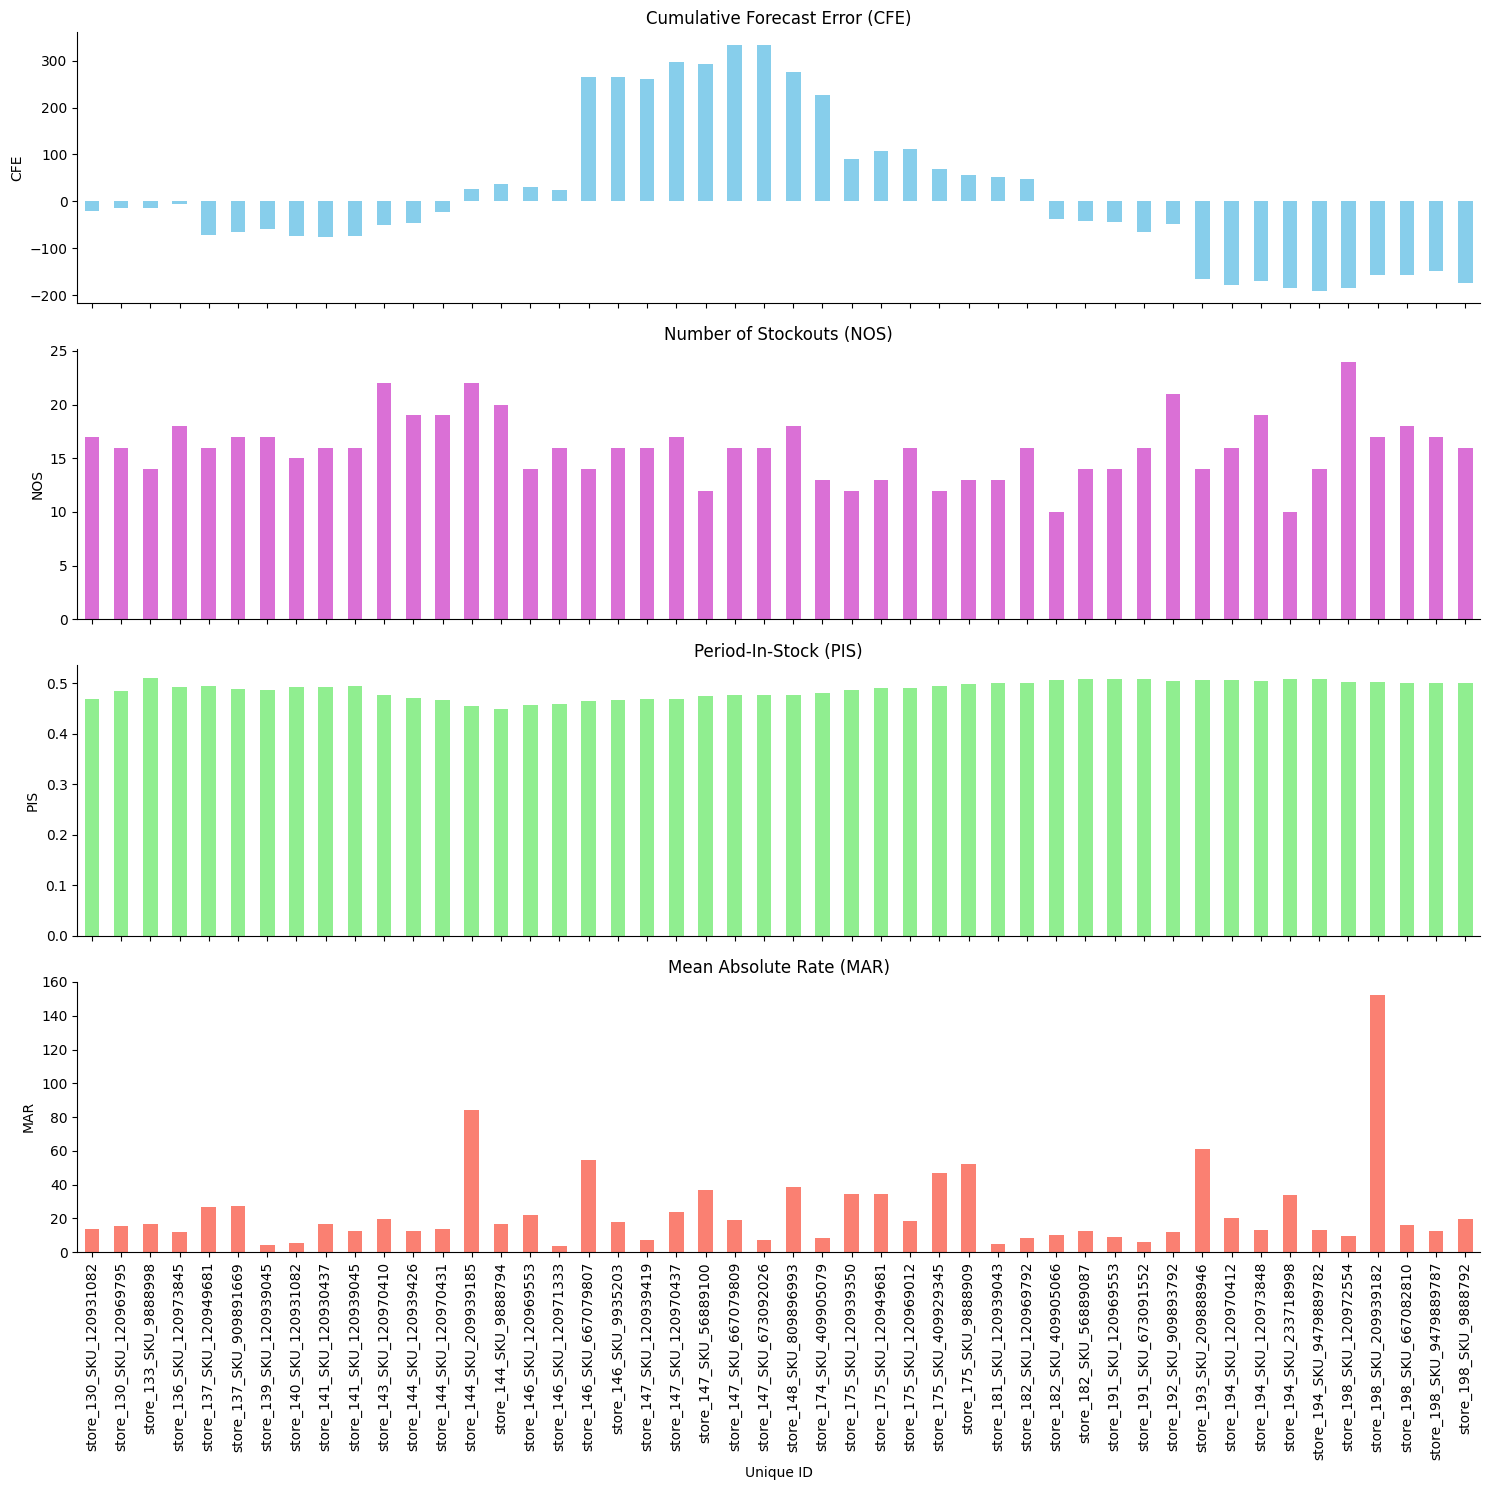

In [145]:
fig, axes = plt.subplots(4, 1, figsize=(15, 15),sharex=True)

# CFE
metrics_df.plot(kind="bar", x="unique_id", y="CFE", ax=axes[0], legend=False, color="skyblue")
axes[0].set_title("Cumulative Forecast Error (CFE)")
axes[0].set_xlabel("Unique ID")
axes[0].set_ylabel("CFE")

# NOS P
metrics_df.plot(kind="bar", x="unique_id", y="NOS", ax=axes[1], legend=False, color="orchid")
axes[1].set_title("Number of Stockouts (NOS)")
axes[1].set_ylabel("NOS")
axes[1].set_xlabel("Unique ID")

# PIS
metrics_df.plot(kind="bar", x="unique_id", y="PIS", ax=axes[2], legend=False, color="lightgreen")
axes[2].set_title("Period-In-Stock (PIS)")
axes[2].set_xlabel("Unique ID")
axes[2].set_ylabel("PIS")

# MAE
metrics_df.plot(kind="bar", x="unique_id", y="MAR", ax=axes[3], legend=False, color="salmon")
axes[3].set_title("Mean Absolute Rate (MAR)")
axes[3].set_xlabel("Unique ID")
axes[3].set_ylabel("MAR")

for ax in axes:
    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# Adjust layout
plt.tight_layout()
plt.show()

#### Cumulative Forecast Error (CFE)

The CFE is the sum of the difference between a forecast and the observed demand.

- **Positive CFE**: Indicates over-forecasting (the model predicts higher demand than actual).
- **Negative CFE**: Indicates under-forecasting (the model predicts lower demand than actual).
- The **CFE plot** shows fluctuations, suggesting varying forecasting accuracy across different `unique_ids`.

#### Number of Stockouts (NOS)

 Count of instances where the forecasted stock is less than the actual demand. Reveals the frequency of stockouts, crucial for inventory management.

 - **Higher NOS Values**: Indicate more frequent stockouts.
 - Several unique_ids have higher NOS values, suggesting frequent instances of stockouts.
 - Some unique_ids have lower NOS values, indicating better stock management or more accurate forecasts.
  
#### Period-In-Stock (PIS)

This is the accumulation of the CFE, which will give insight into what is happening throughout the period. Shows the reliability of the forecast in maintaining stock levels.

- Values close to 1 indicate good performance, where the stock is frequently in supply.
- Lower values indicate more frequent stockouts.
- Most unique_ids have a relatively high PIS, indicating that the forecasted stock was sufficient to meet demand for a significant portion of the time.
- Some unique_ids show slightly lower PIS values, suggesting more frequent stockouts or periods where the forecast did not meet actual demand.

#### Mean Absolute Rate (MAR)

MAR is a measure of the average absolute deviation of the forecasted demand rate from the cumulative mean demand rate. It reflects how well the forecast matches the variability of demand over time.

- The MAR values show significant variation across unique IDs, with some having very high MAR values, indicating large deviations between forecasted and actual demand rates.
- A few unique IDs stand out with exceptionally high MAR values, suggesting these forecasts are less reliable and deviate substantially from the actual demand.
- The MAR metric highlights the overall accuracy and reliability of the forecast in capturing demand trends.
- The **MAR plot** highlights significant variability, with some `unique_ids` showing high error, suggesting areas where the model needs improvement.
  
The CFE, NOS, and PIS metrics help identify areas where the forecast tends to overestimate or underestimate demand, leading to stockouts or overstocks.

## Demand Forecasting with TimeGPT

Nixtla’s TimeGPT is a generative pre-trained forecasting model for time series data. TimeGPT can produce accurate forecasts for new time series without training, using only historical values as inputs. TimeGPT can be used across a plethora of tasks including demand forecasting, anomaly detection, financial forecasting, and more.

#### Splitting the data

In [146]:
test_df = df_forecast.groupby('unique_id').tail(4)     
input_df = df_forecast.drop(test_df.index).reset_index(drop=True)
exog_df = test_df.drop(columns=["y"])

In [147]:
# Load environment variables from a .env file and retrieve the NIXTLA API key
load_dotenv(".env")
api_key=os.getenv("NIXTLA_API_KEY")

#### Initialize NixtlaClient

Create and validate the Nixtla client using the API key.

In [148]:
nixtla_client = NixtlaClient(api_key=api_key)

In [149]:
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io sharing this response and ID: VE5FH9GRYJ


True

In [150]:
# Check the parameters
print(f"horizon: {HORIZON}")
print(f"n_windows: {N_WINDOWS}")
print(f"step_size: {STEP_SIZE}")
print(f"level: {LEVEL}")

horizon: 4
n_windows: 8
step_size: 2
level: [90]


#### Forecast Using TimeGPT

In [151]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=HORIZON,
    X_df=exog_df,
    level=LEVEL,
    finetune_steps=10,
    finetune_loss="mae",
    time_col="ds",
    target_col="y",
    id_col="unique_id",
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-MON
INFO:nixtla.nixtla_client:Using the following exogenous variables: UNITS_MIN, UNITS_MAX, UNITS_MEAN, UNITS_STD, TRANSACTIONS_SUM, PROMO_MAX, PRICE_MEAN
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 4.50141453742981


#### Plot the Forecast

In [152]:
nixtla_client.plot(
    test_df,
    fcst_df,
    models=["TimeGPT"],
    level=LEVEL,
    time_col="ds",
    target_col="y",
    engine="plotly",
)

#### Evaluate the Forecast

 Merge the forecasted data with the validation set and evaluate the performance using MAE and RMSE metrics.

In [153]:
from utilsforecast.losses import mae,smape


fcst_df["ds"] = pd.to_datetime(fcst_df["ds"])
res_gpt = pd.merge(test_df, fcst_df, "left", ["unique_id", "ds"])


evaluation_gpt = evaluate(
    res_gpt,
    metrics=[mae,smape],
    models=["TimeGPT"],
    target_col="y",
    id_col="unique_id",

)

In [154]:
evaluation_gpt.groupby("metric")["TimeGPT"].agg(["mean", "std"])

,mean,std
metric,,
mae,20.064250,26.893934
smape,0.087343,0.068339


#### Perform Cross-Validation

Conduct cross-validation on the entire dataset to ensure robustness of the model.

In [155]:
timegpt_cv_df = nixtla_client.cross_validation(
    df_forecast,
    h=HORIZON,
    n_windows=N_WINDOWS,
    time_col="ds",
    target_col="y",
    freq="W-MON",
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Using the following exogenous variables: UNITS_MIN, UNITS_MAX, UNITS_MEAN, UNITS_STD, TRANSACTIONS_SUM, PROMO_MAX, PRICE_MEAN
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


#### Visualize Cross-Validation Results

In [156]:
nixtla_client.plot(
    df_forecast,
    timegpt_cv_df[["unique_id","ds","TimeGPT"]],
    engine="plotly"
)

#### Evaluate Cross-Validation Performance

In [157]:
evaluation_gpt_cv = evaluate(
    timegpt_cv_df,
    metrics=[mae,smape],
    models=["TimeGPT"],
    target_col="y",
    id_col="unique_id",
)

#### Cross-Validation Results

In [158]:
evaluation_gpt_cv.groupby("metric")["TimeGPT"].agg(["mean", "std"])

,mean,std
metric,,
mae,16.844512,19.599907
smape,0.074268,0.051462


#### Model Performance Visualization

In [159]:
def get_eval_metrics(evaluation_gpt_cv, evaluation_mstl_cv_mae, evaluation_mstl_cv_smape):
    """
    Extracts MAE and RMSE metrics for TimeGPT and MSTL models, and merges them.

    Parameters:
    - evaluation_gpt_cv (pd.DataFrame): Evaluation DataFrame for TimeGPT containing metrics.
    - evaluation_mstl_cv_mae (pd.DataFrame): Evaluation DataFrame for MSTL containing MAE metrics.
    - evaluation_mstl_cv_smape (pd.DataFrame): Evaluation DataFrame for MSTL containing SMAPE metrics.

    Returns:
    - pd.DataFrame: Merged DataFrame with unique_id, TimeGPT MAE, and MSTL MAE and RMSE.
    """
    eval_timegpt_cv_mae = evaluation_gpt_cv[evaluation_gpt_cv["metric"] == "mae"][["unique_id", "TimeGPT"]]
    eval_timegpt_cv_smape = evaluation_gpt_cv[evaluation_gpt_cv["metric"] == "smape"][["unique_id", "TimeGPT"]]
    eval_smape_mae_mstl = pd.merge(evaluation_mstl_cv_mae, evaluation_mstl_cv_smape, on="unique_id")
    eval_smape_mae_mstl.reset_index(inplace=True)

    return eval_timegpt_cv_mae, eval_timegpt_cv_smape, eval_smape_mae_mstl

In [160]:
eval_timegpt_cv_mae, eval_timegpt_cv_smape, eval_smape_mae_mstl = get_eval_metrics(evaluation_gpt_cv, evaluation_mstl_cv_mae, evaluation_mstl_cv_smape)

In [161]:
def add_error_column(df, actual_col, predicted_col):
    """
    Adds an error column to a DataFrame based on the difference between the actual and predicted values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the actual and predicted values.
    actual_col (str): The name of the column containing the actual values.
    predicted_col (str): The name of the column containing the predicted values.

    Returns:
    pd.DataFrame: The DataFrame with the new error column added.
    """
    
    df["error_abs"] = np.abs(df[actual_col] - df[predicted_col])
    df["error_"] = df[actual_col] - df[predicted_col]
    return df

In [162]:
crossvalidation_df_mstl = add_error_column(crossvalidation_df_mstl, "y", "MSTL")
timegpt_cv_df = add_error_column(timegpt_cv_df, "y", "TimeGPT")

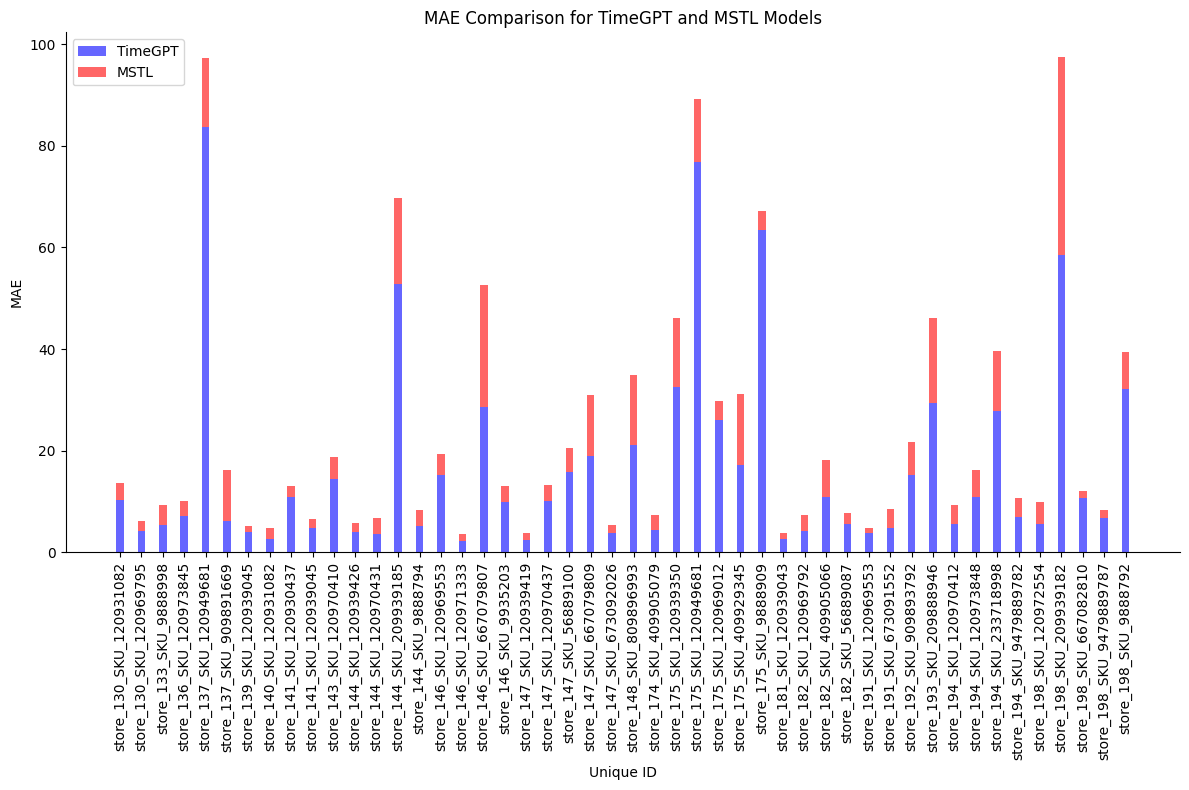

In [163]:
width = 0.35

fig, axs = plt.subplots(figsize=(12, 8))

axs.bar(
    eval_timegpt_cv_mae["unique_id"],
    eval_timegpt_cv_mae["TimeGPT"],
    width,
    label="TimeGPT",
    color="b",
    alpha=0.6,
)
axs.bar(
    eval_smape_mae_mstl["unique_id"],
    eval_smape_mae_mstl["MSTL_mae"],
    width,
    label="MSTL",
    color="r",
    alpha=0.6,
    bottom=eval_timegpt_cv_mae["TimeGPT"],
)

# Customizing the bar plot
axs.set_xlabel("Unique ID")
axs.set_ylabel("MAE")
axs.set_title("MAE Comparison for TimeGPT and MSTL Models")
axs.legend()
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.tick_params(axis="x", rotation=90)

axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

# Show the combined plot
plt.tight_layout()
plt.show()

- The MSTL model consistently achieves lower Mean Absolute Error (MAE) values compared to the TimeGPT model across most unique IDs.
- This indicates that the MSTL model generally provides more accurate predictions for the majority of store and SKU combinations.
- The MSTL model outperforms the TimeGPT model in terms of overall accuracy, as evidenced by the lower MAE values.

#### Error Analysis

This error analysis helps in understanding the error distribution and identifying areas where the models can be improved.

In [164]:
# MSTL error quantiles
crossvalidation_df_mstl[["y", "MSTL", "error_abs"]].describe([0.7, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,50%,70%,80%,90%,95%,99%,max
y,1536.0,116.420860,117.729195,7.000000,73.000000,114.000000,168.000000,259.500000,398.750000,505.000000,1263.000000
MSTL,1536.0,116.534538,117.434235,-7.863361,73.506863,114.574203,166.720703,259.155624,402.694397,507.229431,1239.822266
error_abs,1536.0,6.494394,10.606213,0.001400,2.940297,6.127014,8.932001,16.441643,24.655142,51.241245,125.058624


In [165]:
# TimeGPT error quantiles
timegpt_cv_df[["y", "TimeGPT", "error_abs"]].describe([0.7, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,50%,70%,80%,90%,95%,99%,max
y,1536.0,115.186478,115.505403,2.000000,72.000000,108.805000,163.000000,254.500000,405.250000,524.600000,1263.000000
TimeGPT,1536.0,118.203973,119.598659,-65.911036,71.726481,107.203879,167.513115,274.879559,412.104381,539.418692,783.144529
error_abs,1536.0,16.844512,32.871438,0.006061,5.906795,13.450920,20.378603,40.325256,73.504694,159.686003,479.855471


The MSTL model generally performs better than the TimeGPT model in terms of both average performance and consistency. MSTL has lower mean and median errors, a smaller standard deviation of errors, and significantly lower worst-case errors. These factors suggest that MSTL is a more reliable model for this dataset, with more accurate and consistent predictions.

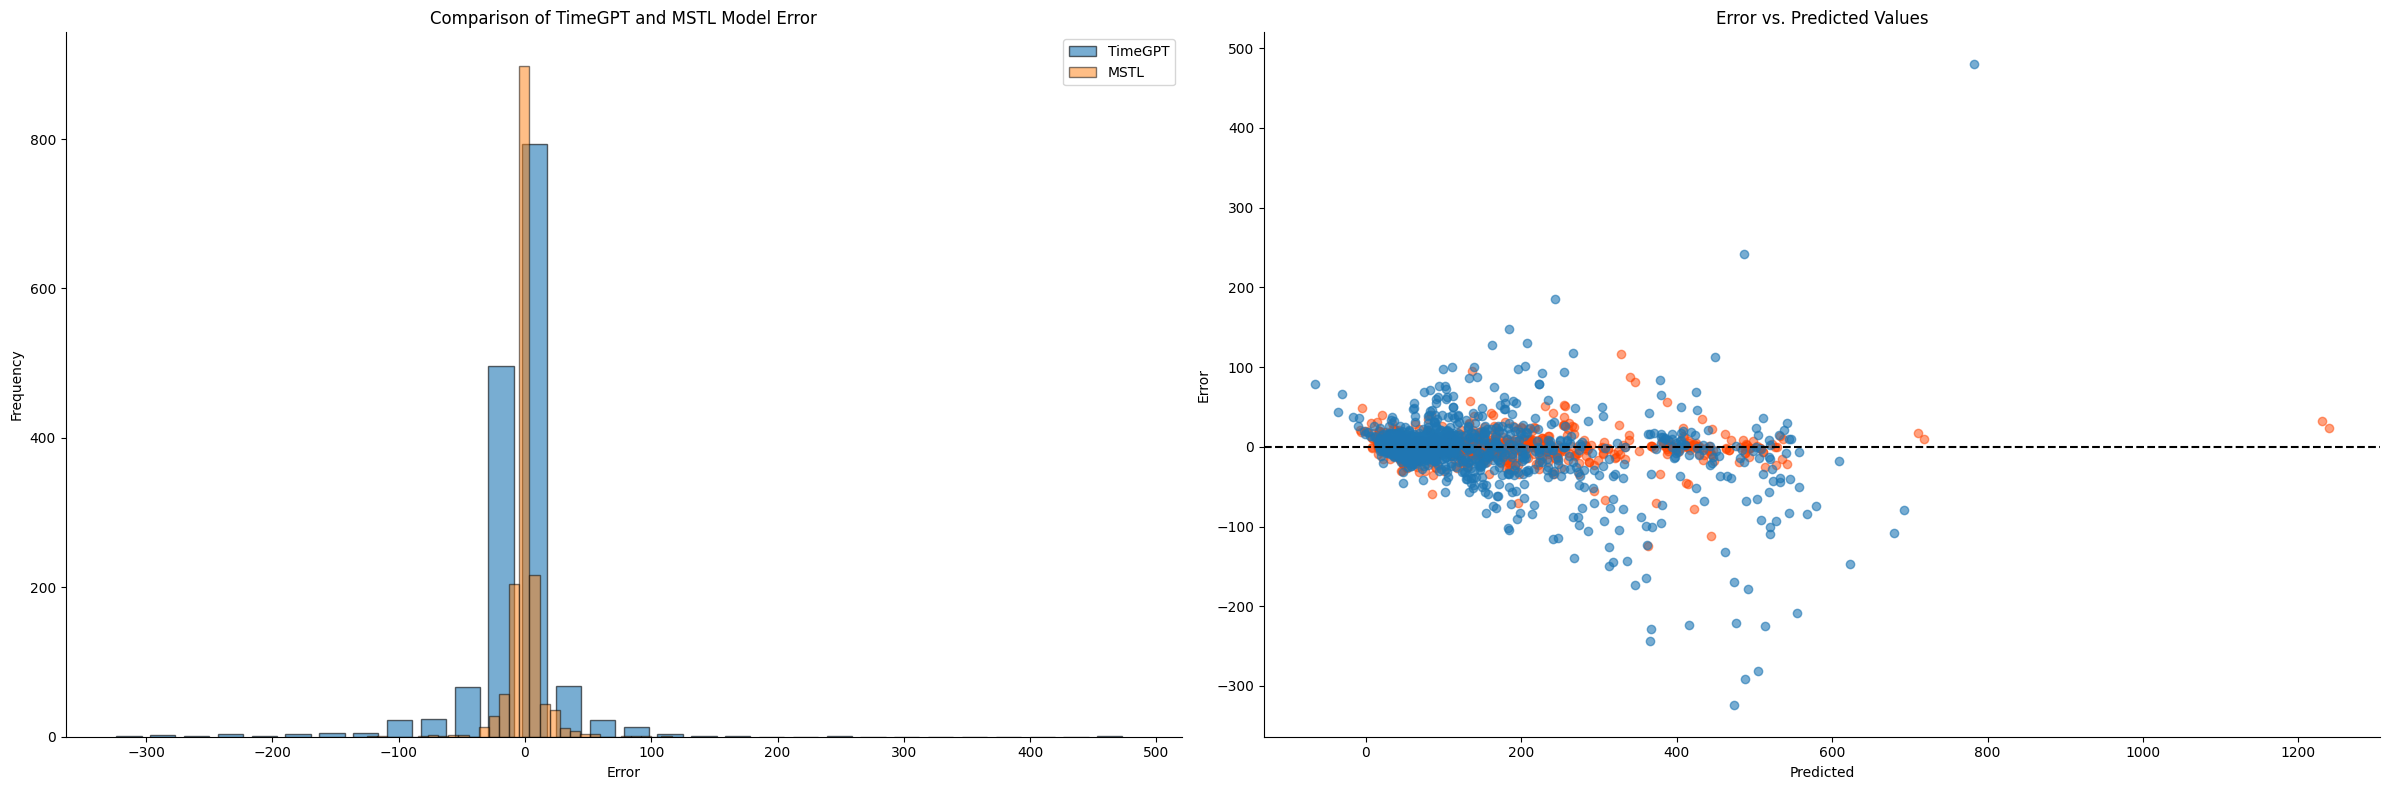

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
# Plotting the histograms
axs[0].hist(
    timegpt_cv_df["error_"],
    bins=30,
    edgecolor="k",
    alpha=0.6,
    label="TimeGPT",
    width=20,
)

# Plot MSTL histogram
axs[0].hist(
    crossvalidation_df_mstl["error_"], bins=30, edgecolor="k", alpha=0.5, label="MSTL"
)

# Customizing the histograms
axs[0].set_xlabel("Error")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Comparison of TimeGPT and MSTL Model Error")
axs[0].legend()

axs[1].scatter(
    crossvalidation_df_mstl["MSTL"],
    crossvalidation_df_mstl["error_"],
    alpha=0.5,
    c="orangered",
)
axs[1].scatter(
    timegpt_cv_df["TimeGPT"], timegpt_cv_df["error_"], alpha=0.6, c="tab:blue"
)

# Customizing the histograms
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Error")
axs[1].set_title("Error vs. Predicted Values")
axs[1].axhline(y=0, color="black", linestyle="--")


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Show the combined plot
plt.tight_layout()
plt.show()

**Histogram of Residuals**

- Both models have a high concentration of residuals around zero, indicating that the majority of the predictions are close to the actual values.
- The MSTL model (orange bars) shows a slightly tighter distribution around zero compared to the TimeGPT model (blue bars), suggesting that MSTL predictions are generally more accurate.
- There are fewer extreme residuals (both positive and negative) for the MSTL model compared to the TimeGPT model. This indicates that the MSTL model has fewer large errors and is more robust.
  
**Scatter Plot of Residuals vs. Predicted Values** 

- The residuals are mostly centered around the zero line, indicating no obvious bias in the predictions.
- There is a slight increase in the spread of residuals as the predicted values increase, suggesting that both models may have higher variability in their errors for larger predictions.
- Both models have a similar pattern, but the MSTL model (orange dots) seems to have fewer large residuals compared to the TimeGPT model (blue dots).
- The horizontal line at zero helps to visualize that most residuals are clustered around this line, further indicating that the predictions are generally accurate.

**Conclusion**

- The MSTL model generally provides more accurate and robust predictions compared to the TimeGPT model, as evidenced by the tighter distribution of residuals around zero and fewer extreme residuals.
- Both models do not show obvious bias in their predictions, as most residuals are centered around zero.
- Both models exhibit higher variability in their errors for larger predicted values, which suggests that further model tuning or additional features may be needed to improve performance for these cases.

### MLflow

In [167]:
import mlflow
from statsforecast import StatsForecast
from sklearn.metrics import mean_absolute_error
import mlflavors

In [168]:
def custom_smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)

    Parameters:
    y_true (numpy array or list): Array of actual values
    y_pred (numpy array or list): Array of predicted values

    Returns:
    float: SMAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [169]:
ARTIFACT_PATH = "model"
DATA_PATH = "./data"
# Define HORIZON and LEVEL
HORIZON = 4
LEVEL = [90]

In [170]:
with mlflow.start_run() as run:

    X_test = test_data.drop(columns=["y"])
    y_test = test_data[["y"]]

    sf = StatsForecast(df=train_data, models=models_mstl, freq="W-MON", n_jobs=-1)

    sf.fit()

    # Evaluate model
    y_pred = sf.predict(h=HORIZON, X_df=X_test, level=LEVEL)["MSTL"]

    metrics = {
        "mae": mean_absolute_error(y_test, y_pred),
        "smape": custom_smape(y_test, y_pred),
    }

    print(f"Metrics: \n{metrics}")

    # Log metrics
    mlflow.log_metrics(metrics)

    # Log parameters
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("level", LEVEL)

    # Log model using pickle serialization (default).
    mlflavors.statsforecast.log_model(
        statsforecast_model=sf,
        artifact_path=ARTIFACT_PATH,
        serialization_format="pickle",
    )
    model_uri = mlflow.get_artifact_uri(ARTIFACT_PATH)

print(f"\nMLflow run id:\n{run.info.run_id}")

Metrics: 
{'mae': 6.972873224218687, 'smape': 0.7521288414425913}


2024/06/12 14:45:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\emirh\AppData\Local\Temp\tmp_jf1fmqo\model\model.pkl, flavor: statsforecast). Fall back to return ['statsforecast==1.7.4']. Set logging level to DEBUG to see the full traceback. 



MLflow run id:
d862726a798e4befb5fa8f9b66fd069d
